# Tarea 3 Redes complejas

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import community as community_louvain
from modularity_maximization.utils import get_modularity
import random
from scipy.optimize import curve_fit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import community as community_louvain
from itertools import combinations

from IPython.display import display, Latex
plt.rcParams.update({'figure.figsize': (6.4, 4.8)})

## Pregunta 1

Para utilizar la función de Networkx se requiere el número de nodos y arcos, así que se calcula el número de arcos como: $Arcos = n^2p/2$

Lo anterior se calcula teniendo en cuenta que $np \approx <k>$ y que $<k> = \sum k_i/n$, con esto se obtiene la suma total de grados del grafo $\sum k_i = n^2 p$, pero como queremos el número de arco y no de grados, se divide por dos.

In [2]:
n = 200  # nodes
p = 0.2 # probability 
m = 0.5*p*n**2  # edges
seed = 20160  # seed random number generators for reproducibility

G = nx.gnm_random_graph(n, m, seed=seed)



Los nodos son $\{a_1, a_2, ..., a_{200}\}$. 
Los grupos ahora son:

- $B_1 = \{a_1, ... a_{100}\}$.
- $B_2 = \{a_{101}, ... a_{200}\}$.
- $C_1 = \{a_1, ... a_{50}, a_{101}, ... , a_{150}\}$.
- $C_2 = \{a_{51}, ... a_{100}, a_{151}, ... , a_{200}\}$.

La probabilidad de ser direccionada hacia alguna dirección es completamente al azar dentro de $B_1$ y $B_2$, pero entre ellas habrá una probabilidad $p$ de ser dirigida de $B_1$ a $B_2$ y $(1-p)$ de $B_2$ a $B_1$.

In [3]:
B = dict()
C = dict()
for i in range(0,50):
    B[i] = 1
    C[i] = 1
for i in range(50,100):
    B[i] = 1
    C[i] = 2
for i in range(100,150):
    B[i] = 2
    C[i] = 1
for i in range(150,200):
    B[i] = 2
    C[i] = 2

In [4]:
def experiment(runs, prob):
    b_list = list()
    c_list = list()
    
    for i in range(runs):
        # First create the graph
        DG = nx.DiGraph()
        # add the nodes
        DG.add_nodes_from(range(0, 200))
        # This section is to add the edges
        # a lot of ifs due to the restrictions
        for u,v in G.edges():
            r = random.random()
            # u and v belongs to the same B sub-set
            if B[u]==B[v]:
                if r <= 0.5:
                    DG.add_edge(u,v)
                else:
                    DG.add_edge(v,u)
            else:
                # u belongs to B1 and v to B2
                if r <= prob and u < v:
                    DG.add_edge(u,v)
                # v belongs to B1 and u to B2
                elif r <= prob and u > v:
                    DG.add_edge(v,u)
                # u belongs to B1 and v to B2
                elif r > prob and u < v:
                    DG.add_edge(v,u)
                else:
                    DG.add_edge(u,v)
        b_list.append(get_modularity(DG, B))
        c_list.append(get_modularity(DG, C))
        
    return (np.mean(b_list), np.mean(c_list))

In [5]:
random.seed(22)
p = -0.1
runs = 100

b_means = list()
c_means = list()

# descomentar para hacer los experimentos
# hay un respaldo de los resultados obtenidos en la siguiente celd

# for i in range（11）：
#     p+=0.1
#     bm, cm = experiment(runs, p)
#     b_means.append(bm)
#     c_means.append(cm)
    

In [6]:
# respaldo porque la ejecución anterior tarda mucho
b_means_r = [0.12162825000000002, 0.07533496499999999, 0.03909329, 0.014192407499999993, -0.0014598675000000046, -0.0067092000000000054, -0.0015244125000000047, 0.013843494999999997, 0.03975669999999999, 0.07578785, 0.12162825000000002]
c_means_r = [0.0018101524999999926, 0.0018077449999999889, 0.00180721499999999, 0.0018182824999999929, 0.0018183549999999946, 0.0018142749999999954, 0.001803892499999994, 0.0017987524999999933, 0.0018044849999999904, 0.0018050274999999887, 0.0018017324999999899]
#b_means_r == b_means
b_means = b_means_r
c_means = c_means_r

In [7]:
x_p = [i*0.1 for i in range(11)]
print(x_p)
print(b_means)
print(c_means)

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]
[0.12162825000000002, 0.07533496499999999, 0.03909329, 0.014192407499999993, -0.0014598675000000046, -0.0067092000000000054, -0.0015244125000000047, 0.013843494999999997, 0.03975669999999999, 0.07578785, 0.12162825000000002]
[0.0018101524999999926, 0.0018077449999999889, 0.00180721499999999, 0.0018182824999999929, 0.0018183549999999946, 0.0018142749999999954, 0.001803892499999994, 0.0017987524999999933, 0.0018044849999999904, 0.0018050274999999887, 0.0018017324999999899]


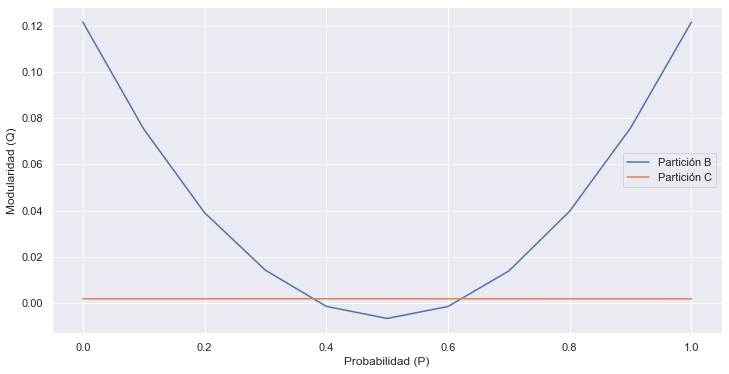

In [8]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(12,6))
sns.lineplot(x=x_p, y=b_means, ax=axs)
sns.lineplot(x=x_p, y=c_means, ax=axs)
axs.legend(["Partición B", 
            "Partición C"])
axs.set_xlabel("Probabilidad (P)")
axs.set_ylabel("Modularidad (Q)")
plt.show()

## Pregunta 2, parte 1

In [9]:
# auxiliar function to make a reverse cumulative sum

def revcumsum(arr):
    l = len(arr)
    cumsum = []
    for i in range(l):
        s = 0
        for j in range(i, l):
            s += arr[j]
        cumsum.append(s)
    return cumsum

In [10]:
H = nx.read_pajek("pescado.net")
H = nx.DiGraph(H)

### Reciprocidad

In [11]:
# in a set there can't be a duplicate item, so it won't be added 
recipr = set()

for u, v in H.edges():
    # if the a edge in the opposite way exist, and it is not in the set yet
    if (v, u) in H.edges() and (v, u) not in recipr:
        # then add the original edge
        recipr.add((u, v))
        
n_H = len(H.nodes)
n_recipr = len(recipr)
m_H = len(H.edges)

In [12]:
rho_1 = n_recipr/m_H
bar_a = m_H/(n_H*(n_H-1))
rho = (rho_1 - bar_a)/(1 - bar_a)
rho

0.12795404435833843

### Reciprocidad con Pesos

In [13]:
recipr = list(recipr)

rho_1_w = 0.0

for u, v in recipr:
    aa = H.edges[(u,v)]["weight"]*H.edges[(v,u)]["weight"]
    rho_1_w += np.sqrt(aa)

m_H_w = 0.0

for edge in H.edges():
    m_H_w += H.edges[edge]["weight"]
    
rho_1_w = rho_1_w/m_H

In [14]:
bar_a_w = m_H_w/(n_H*(n_H-1))
rho_w = (rho_1_w - bar_a_w)/(1 - bar_a_w)
rho_w

-1.246719463854233

### Reciprocidad con Pesos (version alternativa)

In [15]:
recipr = list(recipr)

rho_1_w = 0.0

for u, v in recipr:
    aa = H.edges[(u,v)]["weight"]*H.edges[(v,u)]["weight"]
    rho_1_w += aa

m_H_w = 0.0

for edge in H.edges():
    m_H_w += H.edges[edge]["weight"]
    
rho_1_w = rho_1_w/m_H_w

In [16]:
bar_a_w = m_H_w/(n_H*(n_H-1))
rho_w = (rho_1_w - bar_a_w)/(1 - bar_a_w)
rho_w

-26.027256656897624

### Distribución de Fuerzas

In [17]:
# list of countries
countries = list(H.nodes.keys())
# dictionaries for the sum of the money in and out of each country 
s_in = dict()
s_out = dict()

# initializing the countries in the dictionaries
for c in countries:
    s_in[c] = 0
    s_out[c] = 0
    
# adding the weights (money)
for u, v in H.edges():
    weight = H.edges[(u, v)]["weight"]
    s_in[v] += weight
    s_out[u] += weight

In [18]:
# s_in_values = list(s_in.values())
# s_out_values = list(s_out.values())
s_in_values = [i for i in s_in.values() if i > 0]
s_out_values = [i for i in s_out.values() if i > 0]
n_in = len(s_in_values)
n_out = len(s_out_values)
r_in = np.max(s_in_values) - np.min(s_in_values)
r_out = np.max(s_out_values) - np.min(s_out_values)

iqr_in = np.percentile(s_in_values, 75) - np.percentile(s_in_values, 25)
iqr_out = np.percentile(s_out_values, 75) - np.percentile(s_out_values, 25)

#Freedman-Diaconis
a_in = 2*iqr_in*n_in**(-1/3)
a_out = 2*iqr_out*n_out**(-1/3)

k_in = int(np.round(r_in/a_in, 0))
k_out = int(np.round(r_out/a_out, 0))

hist_in, bin_edges_in = np.histogram(s_in_values, bins=k_in)
hist_out, bin_edges_out = np.histogram(s_out_values, bins=k_out)

In [19]:
x_in = []
y_in = []

for i in range(len(hist_in)):
    if hist_in[i] != 0:
        y_in.append(hist_in[i])
        x_in.append(bin_edges_in[i])
        #x_in.append(np.mean([bin_edges_in[i], bin_edges_in[i+1]]))
        
x_out = []
y_out = []

for i in range(len(hist_out)):
    if hist_out[i] != 0:
        y_out.append(hist_out[i])
        x_out.append(bin_edges_out[i])
        #x_out.append(np.mean([bin_edges_out[i], bin_edges_out[i+1]]))

#### Distribucion $P(S_{in})$ Fuerza de Entrada

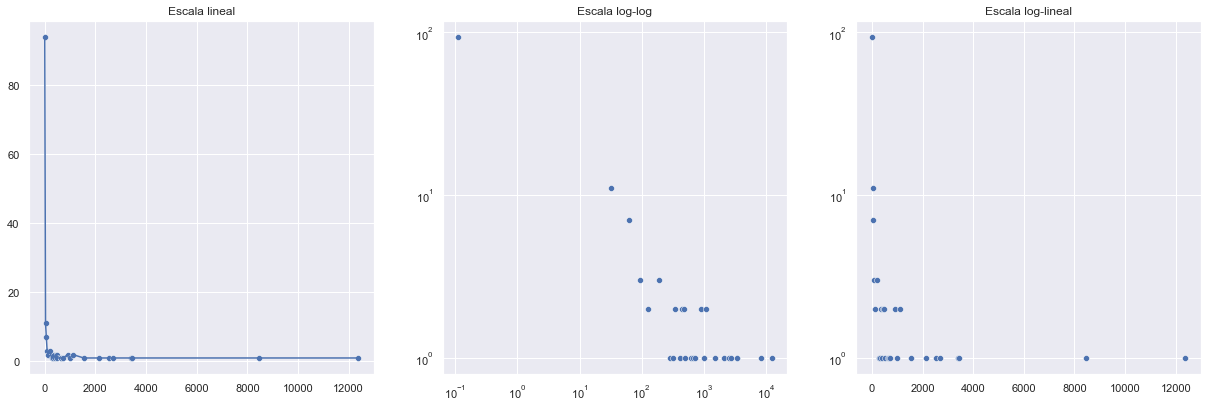

In [20]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6.5))

sns.scatterplot(x=x_in, y=y_in, ax=axs[0])
sns.lineplot(x=x_in, y=y_in, ax=axs[0])
axs[0].set_title("Escala lineal")

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_in, y=y_in, ax=axs[1])
axs[1].set_title("Escala log-log")

axs[2].set(yscale="log")
sns.scatterplot(x=x_in, y=y_in, ax=axs[2])
axs[2].set_title("Escala log-lineal")

plt.show()

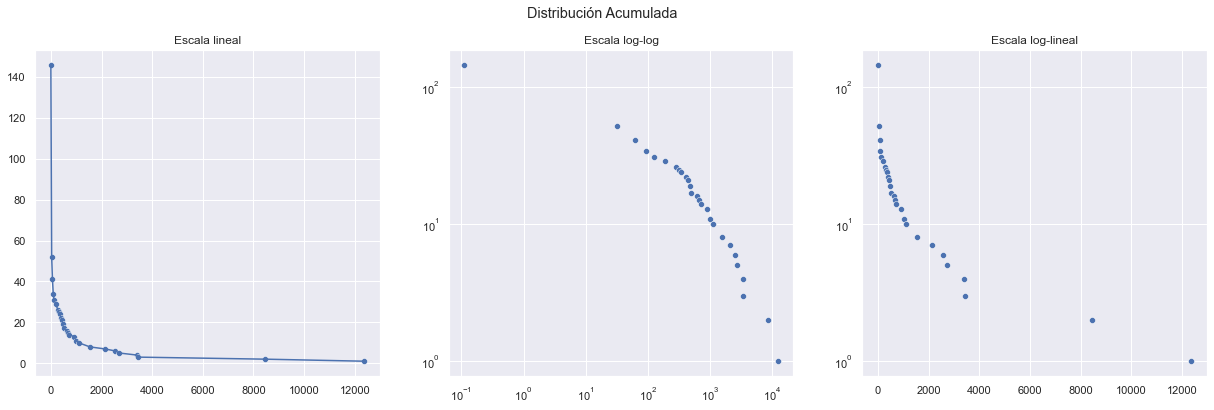

In [21]:
y_in_cum = revcumsum(y_in)

sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6))

sns.scatterplot(x=x_in, y=y_in_cum, ax=axs[0])
sns.lineplot(x=x_in, y=y_in_cum, ax=axs[0])
axs[0].set_title("Escala lineal")

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_in, y=y_in_cum, ax=axs[1])
axs[1].set_title("Escala log-log")

axs[2].set(yscale="log")
sns.scatterplot(x=x_in, y=y_in_cum, ax=axs[2])
axs[2].set_title("Escala log-lineal")

fig.suptitle("Distribución Acumulada")

plt.show()

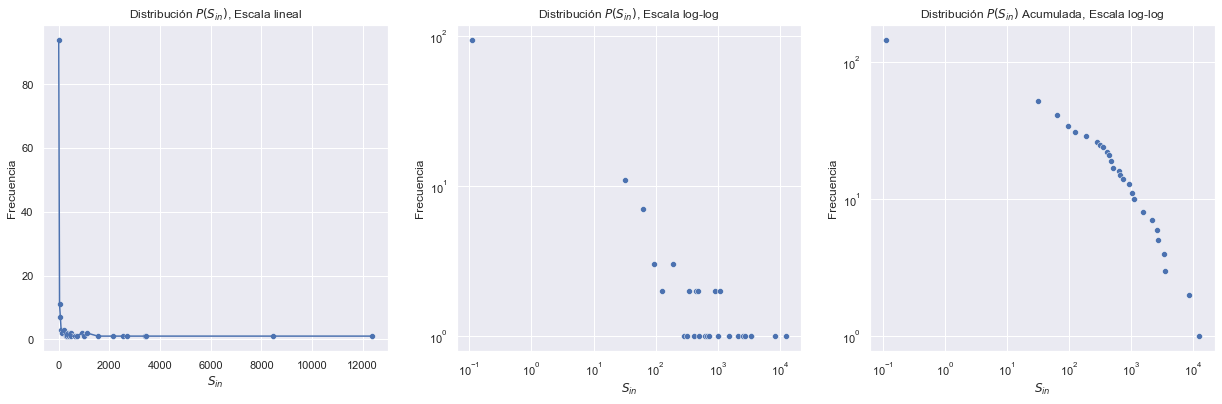

In [22]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6))

sns.scatterplot(x=x_in, y=y_in, ax=axs[0])
sns.lineplot(x=x_in, y=y_in, ax=axs[0])
axs[0].set_title(r"Distribución $P(S_{in})$, Escala lineal")

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_in, y=y_in, ax=axs[1])
axs[1].set_title(r"Distribución $P(S_{in})$, Escala log-log")

axs[2].set(xscale="log", yscale="log")
sns.scatterplot(x=x_in, y=y_in_cum, ax=axs[2])
axs[2].set_title("Distribución $P(S_{in})$ Acumulada, Escala log-log")

for ax in axs:
    ax.set_xlabel(r"$S_{in}$")
    ax.set_ylabel(r"Frecuencia")

plt.show()

$$
F(x) = \frac{\alpha -1}{x_{min}} \cdot \left( \frac{x}{x_{min}} \right)^{-\alpha}
$$

In [23]:
# implicit function to evaluate a powerlaw function
#PWL = lambda x, xmin, alpha: ((alpha-1)/xmin) * ((x/xmin)**(-alpha))
PWL = lambda x, alpha, C: C*(np.power(x, -alpha))

x_min = 550

x_law = np.linspace(np.min(x_in), np.max(x_in), 1000)

# all the variables with min are used to get the range above x_min
x_law_min = [x_law[i] for i in range(len(x_law)) if x_law[i] > x_min]

x_in_min = [x_in[i] for i in range(len(x_in)) if x_in[i] > x_min]
y_in_cum_min = [y_in_cum[i] for i in range(len(x_in)) if x_in[i] > x_min]

# now fit the curve to the powerlaw
popt, pcov = curve_fit(PWL, x_in_min, y_in_cum_min, maxfev = 2000)
alpha, C = popt
perr = np.sqrt(np.diag(pcov))
alpha_err, C_err = perr

# Kolmogorov Smirnov
D_max = np.max(np.abs(PWL(x_in_min, *popt) - y_in_cum_min))

display(Latex(f"$\\alpha = %.3f \pm %.2f$" % (alpha, alpha_err)))
display(Latex(f"$C = %.1f \pm %.1f$" % (C, C_err)))
display(Latex(f"$f(x) = %.1f \cdot X^{{-%.3f}}$" % (C, alpha)))
display(Latex(f"$D = %.3f$" % D_max))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

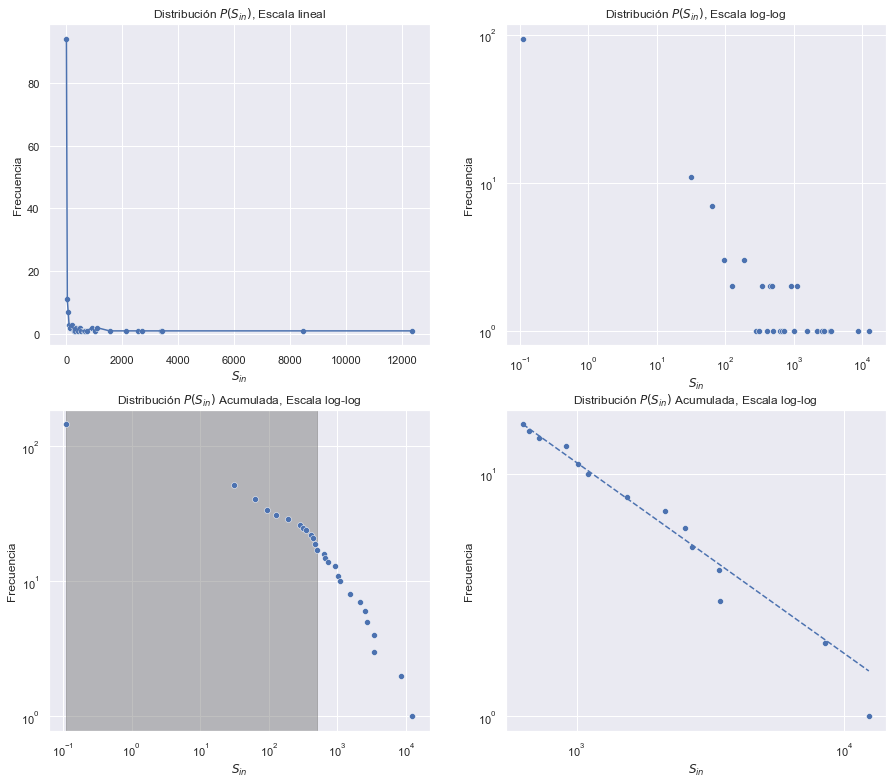

In [24]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,13))

axs = axs.flatten()

sns.scatterplot(x=x_in, y=y_in, ax=axs[0])
sns.lineplot(x=x_in, y=y_in, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_in, y=y_in, ax=axs[1])

axs[2].set(xscale="log", yscale="log")
axs[2].fill_between(x_in, 0, 1, where= np.array(x_in) < x_min,
                    color='grey', alpha=0.5, transform=axs[2].get_xaxis_transform())
sns.scatterplot(x=x_in, y=y_in_cum, ax=axs[2])

axs[3].set(xscale="log", yscale="log")
sns.scatterplot(x=x_in_min, y=y_in_cum_min, ax=axs[3])
axs[3].plot(x_in_min, PWL(x_in_min, *popt), '--')

for ax in axs:
    ax.set_xlabel(r"$S_{in}$")
    ax.set_ylabel(r"Frecuencia")
axs[0].set_title(r"Distribución $P(S_{in})$, Escala lineal")
axs[1].set_title(r"Distribución $P(S_{in})$, Escala log-log")
axs[2].set_title(r"Distribución $P(S_{in})$ Acumulada, Escala log-log")
axs[3].set_title(r"Distribución $P(S_{in})$ Acumulada, Escala log-log")

plt.show()

In [25]:
min_dmax = 1.5
for x_min in range(10, 1000, 10):
    x_in_min = [x_in[i] for i in range(len(x_in)) if x_in[i] > x_min]
    y_in_cum_min = [y_in_cum[i] for i in range(len(x_in)) if x_in[i] > x_min]

    # now fit the curve to the powerlaw
    popt, pcov = curve_fit(PWL, x_in_min, y_in_cum_min, maxfev = 2000)
    D_max = np.max(np.abs(PWL(x_in_min, *popt) - y_in_cum_min))
    if min_dmax >= D_max:
        min_dmax = D_max
        print(x_min, D_max)

<ipython-input-23-00966bd128e9>:3: RuntimeWarning: overflow encountered in power
  PWL = lambda x, alpha, C: C*(np.power(x, -alpha))


290 1.4418863481863307
300 1.4418863481863307
310 1.4418863481863307
320 1.4044426237733418
330 1.4044426237733418
340 1.4044426237733418
410 1.4043236831036303
420 1.4043236831036303
430 1.4043236831036303
440 1.4043236831036303
450 1.401689640481548
460 1.401689640481548
470 1.401689640481548
480 1.3937265362116946
490 1.3937265362116946
500 1.3937265362116946
510 1.2175967258708704
520 1.2175967258708704
530 1.2175967258708704
540 1.2175967258708704
550 1.2175967258708704
560 1.2175967258708704
570 1.2175967258708704
580 1.2175967258708704
590 1.2175967258708704
600 1.2175967258708704
610 1.2175967258708704
620 1.2175967258708704
630 1.2175299796256756
640 1.2175299796256756
650 1.2175299796256756
660 1.2175299796256756
670 1.1701381467727536
680 1.1701381467727536
690 1.1701381467727536
700 1.1701381467727536
710 1.1701381467727536
720 1.1701381467727536
730 1.0758542656599115
740 1.0758542656599115
750 1.0758542656599115
760 1.0758542656599115
770 1.0758542656599115
780 1.07585426

#### Distribucion $P(S_{out})$ Fuerza de Salida

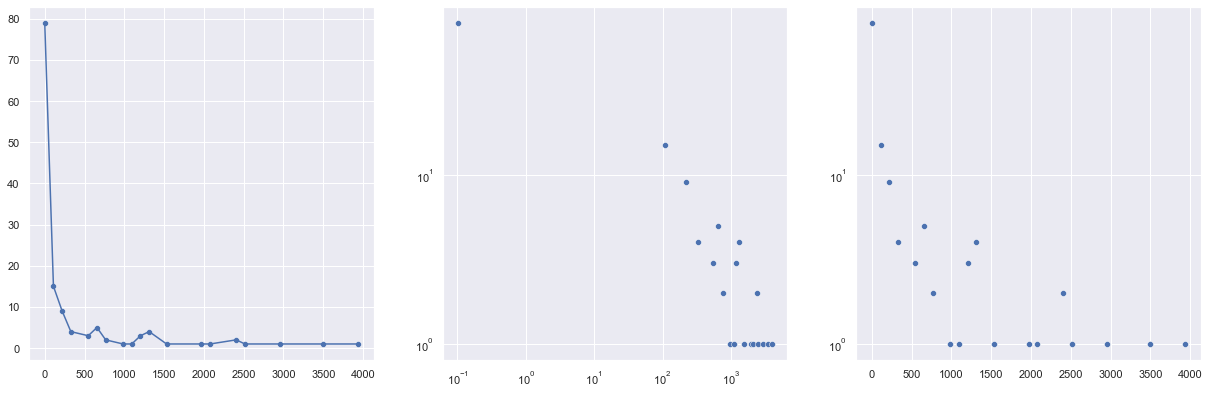

In [26]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6.5))

sns.scatterplot(x=x_out, y=y_out, ax=axs[0])
sns.lineplot(x=x_out, y=y_out, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_out, y=y_out, ax=axs[1])

axs[2].set(yscale="log")
sns.scatterplot(x=x_out, y=y_out, ax=axs[2])

plt.show()

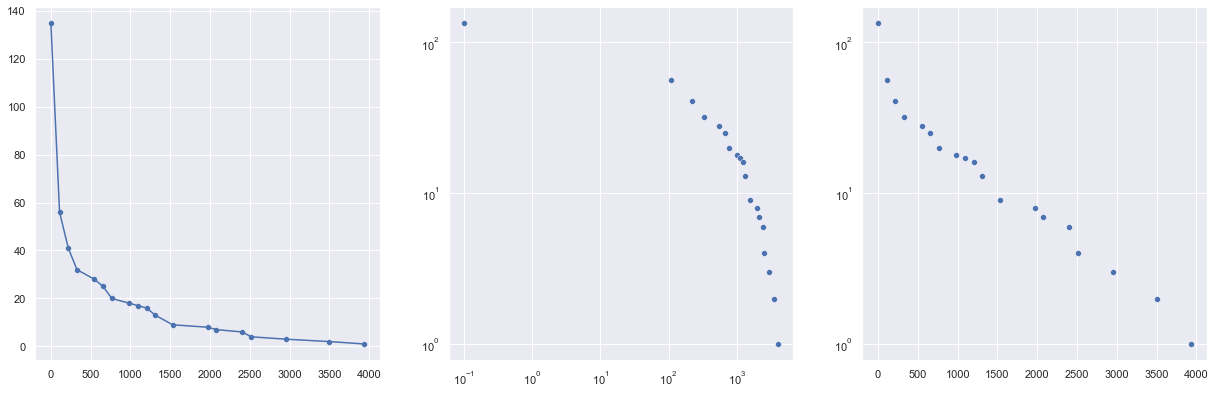

In [27]:
y_out_cum = revcumsum(y_out)

sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6.5))

sns.scatterplot(x=x_out, y=y_out_cum, ax=axs[0])
sns.lineplot(x=x_out, y=y_out_cum, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_out, y=y_out_cum, ax=axs[1])

axs[2].set(yscale="log")
sns.scatterplot(x=x_out, y=y_out_cum, ax=axs[2])

plt.show()

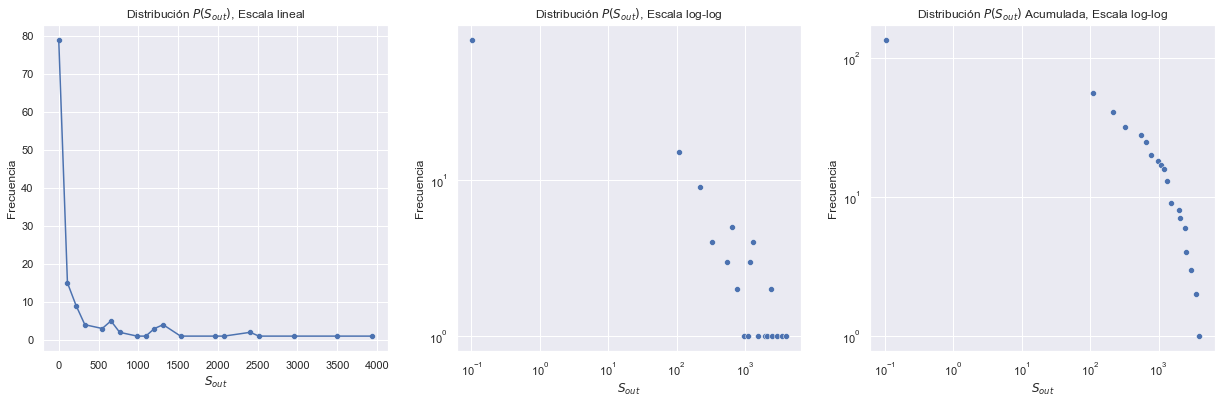

In [28]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6))

sns.scatterplot(x=x_out, y=y_out, ax=axs[0])
sns.lineplot(x=x_out, y=y_out, ax=axs[0])
axs[0].set_title(r"Distribución $P(S_{out})$, Escala lineal")

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_out, y=y_out, ax=axs[1])
axs[1].set_title(r"Distribución $P(S_{out})$, Escala log-log")

axs[2].set(xscale="log", yscale="log")
sns.scatterplot(x=x_out, y=y_out_cum, ax=axs[2])
axs[2].set_title("Distribución $P(S_{out})$ Acumulada, Escala log-log")

for ax in axs:
    ax.set_xlabel(r"$S_{out}$")
    ax.set_ylabel(r"Frecuencia")

plt.show()

In [29]:
# implicit function to evaluate a powerlaw function
#PWL = lambda x, xmin, alpha: ((alpha-1)/xmin) * ((x/xmin)**(-alpha))
PWL = lambda x, alpha, C: C*(np.power(x, -alpha))

x_min = 800

x_law = np.linspace(np.min(x_out), np.max(x_out), 1000)

# all the variables with min are used to get the range above x_min
x_law_min = [x_law[i] for i in range(len(x_law)) if x_law[i] > x_min]

x_out_min = [x_out[i] for i in range(len(x_out)) if x_out[i] > x_min]
y_out_cum_min = [y_out_cum[i] for i in range(len(x_out)) if x_out[i] > x_min]

# now fit the curve to the powerlaw
popt, pcov = curve_fit(PWL, x_out_min, y_out_cum_min, maxfev = 2000)
alpha, C = popt
perr = np.sqrt(np.diag(pcov))
alpha_err, C_err = perr

# Kolmogorov Smirnov
D_max = np.max(np.abs(PWL(x_out_min, *popt) - y_out_cum_min))

display(Latex(f"$\\alpha = %.3f \pm %.2f$" % (alpha, alpha_err)))
display(Latex(f"$C = %.1f \pm %.1f$" % (C, C_err)))
display(Latex(f"$f(x) = %.1f \cdot X^{{-%.3f}}$" % (C, alpha)))
display(Latex(f"$D = %.3f$" % D_max))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

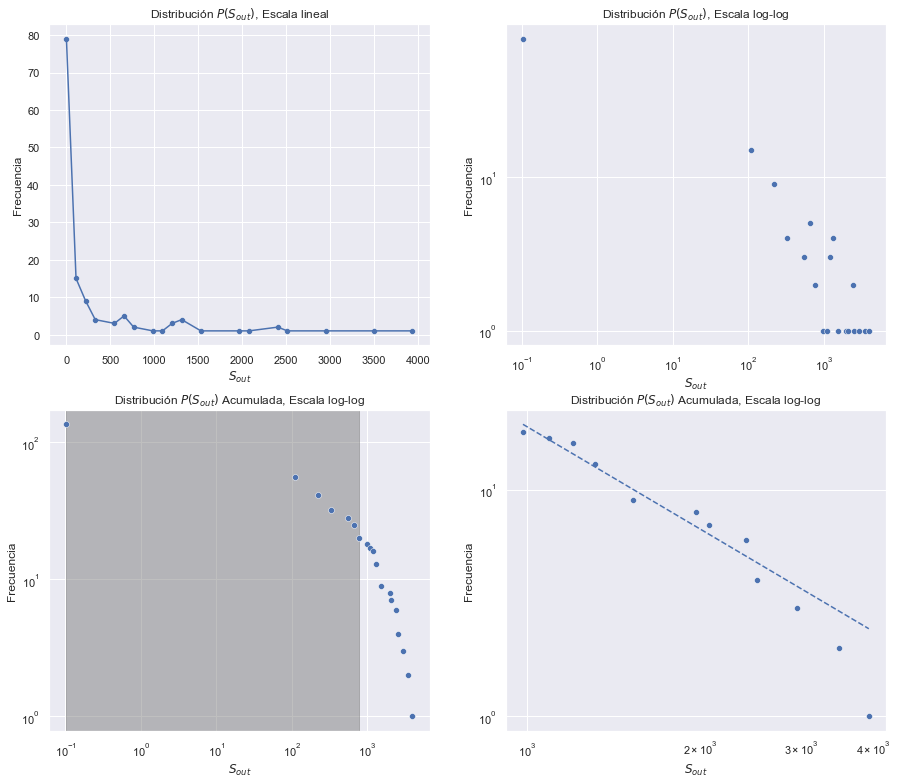

In [30]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,13))

axs = axs.flatten()

sns.scatterplot(x=x_out, y=y_out, ax=axs[0])
sns.lineplot(x=x_out, y=y_out, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_out, y=y_out, ax=axs[1])

axs[2].set(xscale="log", yscale="log")
axs[2].fill_between(x_out, 0, 1, where= np.array(x_out) < x_min,
                    color='grey', alpha=0.5, transform=axs[2].get_xaxis_transform())
sns.scatterplot(x=x_out, y=y_out_cum, ax=axs[2])

axs[3].set(xscale="log", yscale="log")
sns.scatterplot(x=x_out_min, y=y_out_cum_min, ax=axs[3])
axs[3].plot(x_out_min, PWL(x_out_min, *popt), '--')

for ax in axs:
    ax.set_xlabel(r"$S_{out}$")
    ax.set_ylabel(r"Frecuencia")
axs[0].set_title(r"Distribución $P(S_{out})$, Escala lineal")
axs[1].set_title(r"Distribución $P(S_{out})$, Escala log-log")
axs[2].set_title(r"Distribución $P(S_{out})$ Acumulada, Escala log-log")
axs[3].set_title(r"Distribución $P(S_{out})$ Acumulada, Escala log-log")

plt.show()

In [31]:
min_dmax = 3.0
for x_min in range(10, 1000, 10):
    x_out_min = [x_out[i] for i in range(len(x_out)) if x_out[i] > x_min]
    y_out_cum_min = [y_out_cum[i] for i in range(len(x_out)) if x_out[i] > x_min]

    # now fit the curve to the powerlaw
    popt, pcov = curve_fit(PWL, x_out_min, y_out_cum_min, maxfev = 2000)
    D_max = np.max(np.abs(PWL(x_out_min, *popt) - y_out_cum_min))
    if min_dmax >= D_max:
        min_dmax = D_max
        print(x_min, D_max)

550 2.901695595866199
560 2.901695595866199
570 2.901695595866199
580 2.901695595866199
590 2.901695595866199
600 2.901695595866199
610 2.901695595866199
620 2.901695595866199
630 2.901695595866199
640 2.901695595866199
650 2.901695595866199
770 1.6081570369767153
780 1.6081570369767153
790 1.6081570369767153
800 1.6081570369767153
810 1.6081570369767153
820 1.6081570369767153
830 1.6081570369767153
840 1.6081570369767153
850 1.6081570369767153
860 1.6081570369767153
870 1.6081570369767153
880 1.6081570369767153
890 1.6081570369767153
900 1.6081570369767153
910 1.6081570369767153
920 1.6081570369767153
930 1.6081570369767153
940 1.6081570369767153
950 1.6081570369767153
960 1.6081570369767153
970 1.6081570369767153
980 1.6081570369767153
990 1.2218415713736173


### Dispersión de Fuerzas $S_{in}$ y $S_{out}$

In [32]:
x_disp_in = []
y_disp_out = []
for c in countries:
    sin = s_in[c]
    sout = s_out[c]
    # let out of the anaylisis the countries with zero in the s in or s out
    if(sin!=0) and (sout!=0):
        x_disp_in.append(sin)
        y_disp_out.append(sout)
        
print("Total amount of countries ", len(countries))
print("Total amount of considered countries ", len(x_disp_in))

Total amount of countries  151
Total amount of considered countries  130


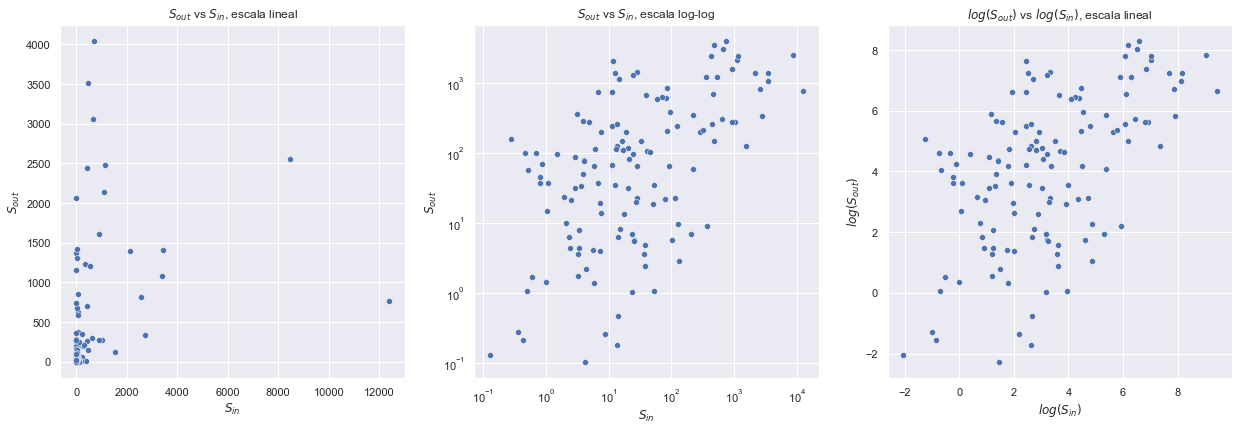

In [33]:
log_x_disp_in = np.log(x_disp_in)
log_y_disp_out = np.log(y_disp_out)

sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6.5))

sns.scatterplot(x=x_disp_in, y=y_disp_out, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_disp_in, y=y_disp_out, ax=axs[1])

sns.scatterplot(x=log_x_disp_in, y=log_y_disp_out, ax=axs[2])

for ax in axs:
    ax.set_xlabel(r"$S_{in}$")
    ax.set_ylabel(r"$S_{out}$")
axs[0].set_title(r"$S_{out}$ vs $S_{in}$, escala lineal")
axs[1].set_title(r"$S_{out}$ vs $S_{in}$, escala log-log")
axs[2].set_title(r"$log(S_{out})$ vs $log(S_{in})$, escala lineal")
ax.set_xlabel(r"$log(S_{in})$")
ax.set_ylabel(r"$log(S_{out})$")

plt.show()

In [34]:
x_fit = log_x_disp_in[:, np.newaxis]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_fit, log_y_disp_out)

# Make predictions using the testing set
y_pred = regr.predict(x_fit)

# The coefficients and intercept
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(log_y_disp_out, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(log_y_disp_out, y_pred))

Coefficients: 
 [0.556571]
Intercept: 
 2.210606330360497
Mean squared error: 4.37
Coefficient of determination: 0.29


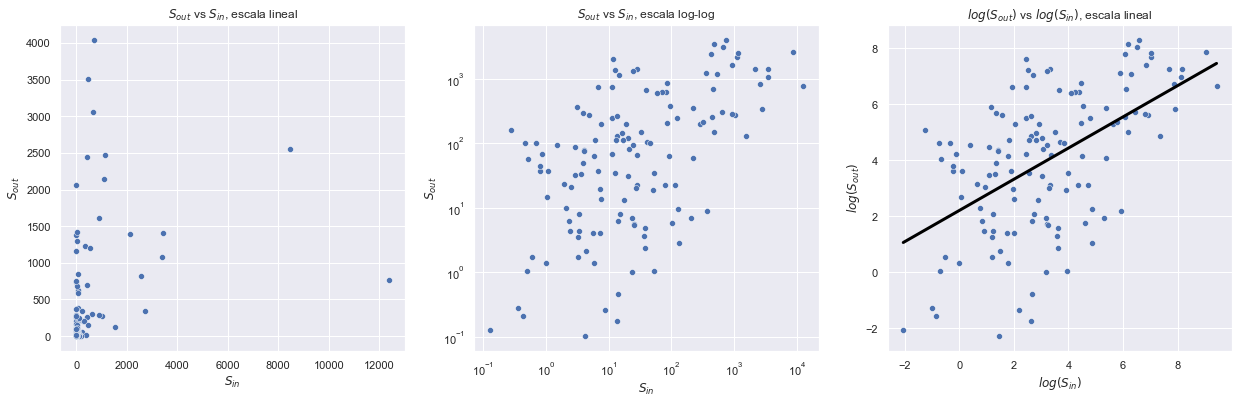

In [35]:
log_x_disp_in = np.log(x_disp_in)
log_y_disp_out = np.log(y_disp_out)

sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6))

sns.scatterplot(x=x_disp_in, y=y_disp_out, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_disp_in, y=y_disp_out, ax=axs[1])

sns.lineplot(x=x_fit[:,0], y=y_pred, linewidth=3, color="black", ax=axs[2])
sns.scatterplot(x=log_x_disp_in, y=log_y_disp_out, ax=axs[2])

for ax in axs:
    ax.set_xlabel(r"$S_{in}$")
    ax.set_ylabel(r"$S_{out}$")
axs[0].set_title(r"$S_{out}$ vs $S_{in}$, escala lineal")
axs[1].set_title(r"$S_{out}$ vs $S_{in}$, escala log-log")
axs[2].set_title(r"$log(S_{out})$ vs $log(S_{in})$, escala lineal")
ax.set_xlabel(r"$log(S_{in})$")
ax.set_ylabel(r"$log(S_{out})$")

plt.show()

## Pregunta 2, parte 2

In [36]:
# changing into a no directed graph
# when this is done, the weights are preserved
# if two nodes had two edges, it preserves the weight of one of them ignoring the other one
H2 = nx.Graph(H)

# recipr have all the a_ij edges that have an a_ji in the original network
# thus, this for adds the weights of the original edges and override the weight in the new network
for u, v in recipr:
    weight = H.edges()[(u, v)]["weight"]
    weight += H.edges()[(v, u)]["weight"]
    H2.edges()[(u, v)]["weight"] = weight

### Distribuciones

#### Distribución de Grados $P(K)$

In [37]:
H2_degrees = [H2.degree[c] for c in countries]

n_deg = len(H2_degrees)
r_deg = np.max(H2_degrees) - np.min(H2_degrees)

iqr_deg = np.percentile(H2_degrees, 75) - np.percentile(H2_degrees, 25)

#Freedman-Diaconis
a_deg = 2*iqr_deg*n_deg**(-1/3)

k_deg = int(np.round(r_deg/a_deg, 0))

hist_deg, bin_edges_deg = np.histogram(H2_degrees, bins=k_deg)


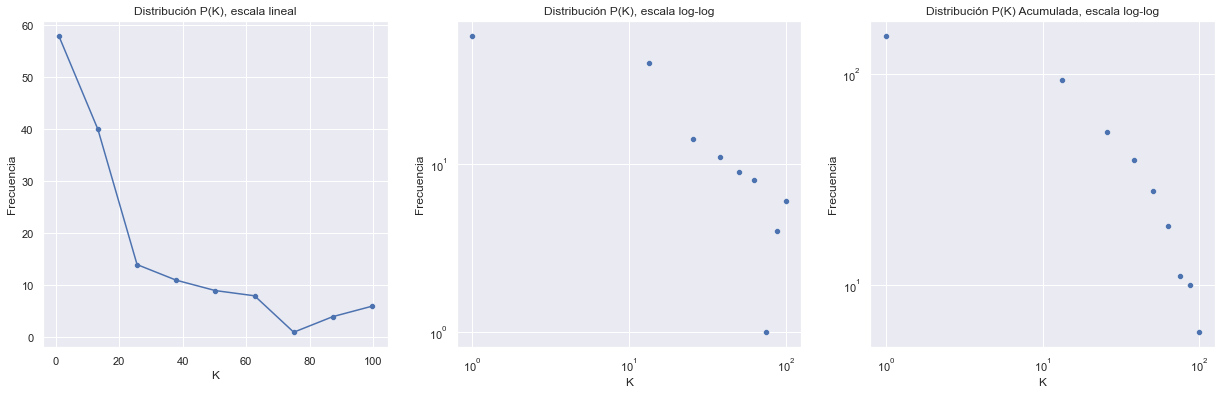

In [38]:
x_deg = bin_edges_deg[:len(hist_deg)]
y_deg = hist_deg
y_deg_cum = revcumsum(y_deg)

sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6))

sns.scatterplot(x=x_deg, y=y_deg, ax=axs[0])
sns.lineplot(x=x_deg, y=y_deg, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_deg, y=y_deg, ax=axs[1])

axs[2].set(xscale="log", yscale="log")
sns.scatterplot(x=x_deg, y=y_deg_cum, ax=axs[2])

for ax in axs:
    ax.set_xlabel("K")
    ax.set_ylabel("Frecuencia")
axs[0].set_title("Distribución P(K), escala lineal")
axs[1].set_title("Distribución P(K), escala log-log")
axs[2].set_title("Distribución P(K) Acumulada, escala log-log")

plt.show()

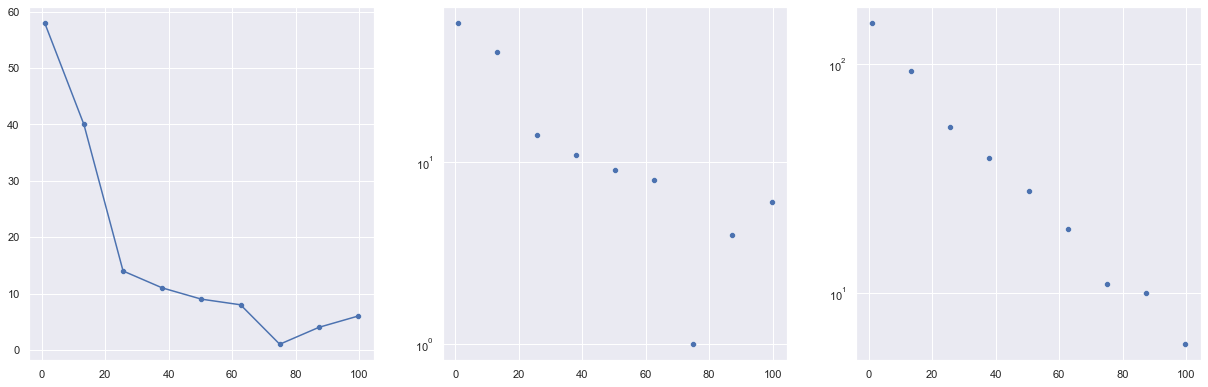

In [39]:
x_deg = bin_edges_deg[:len(hist_deg)]
y_deg = hist_deg
y_deg_cum = revcumsum(y_deg)

sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6.5))

sns.scatterplot(x=x_deg, y=y_deg, ax=axs[0])
sns.lineplot(x=x_deg, y=y_deg, ax=axs[0])

axs[1].set(yscale="log")
sns.scatterplot(x=x_deg, y=y_deg, ax=axs[1])

axs[2].set(yscale="log")
sns.scatterplot(x=x_deg, y=y_deg_cum, ax=axs[2])

plt.show()

In [40]:
# implicit function to evaluate a powerlaw function
#PWL = lambda x, xmin, alpha: ((alpha-1)/xmin) * ((x/xmin)**(-alpha))
PWL = lambda x, alpha, C: C*(np.power(x, -alpha))

x_min = 40

x_law = np.linspace(np.min(x_deg), np.max(x_deg), 1000)

# all the variables with min are used to get the range above x_min
x_law_min = [x_law[i] for i in range(len(x_law)) if x_law[i] > x_min]

x_deg_min = [x_deg[i] for i in range(len(x_deg)) if x_deg[i] > x_min]
y_deg_cum_min = [y_deg_cum[i] for i in range(len(x_deg)) if x_deg[i] > x_min]

# now fit the curve to the powerlaw
popt, pcov = curve_fit(PWL, x_deg_min, y_deg_cum_min, maxfev = 2000)
alpha, C = popt
perr = np.sqrt(np.diag(pcov))
alpha_err, C_err = perr

# Kolmogorov Smirnov
D_max = np.max(np.abs(PWL(x_deg_min, *popt) - y_deg_cum_min))

display(Latex(f"$\\alpha = %.3f \pm %.2f$" % (alpha, alpha_err)))
display(Latex(f"$C = %.1f \pm %.1f$" % (C, C_err)))
display(Latex(f"$f(x) = %.1f \cdot X^{{-%.3f}}$" % (C, alpha)))
display(Latex(f"$D = %.3f$" % D_max))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

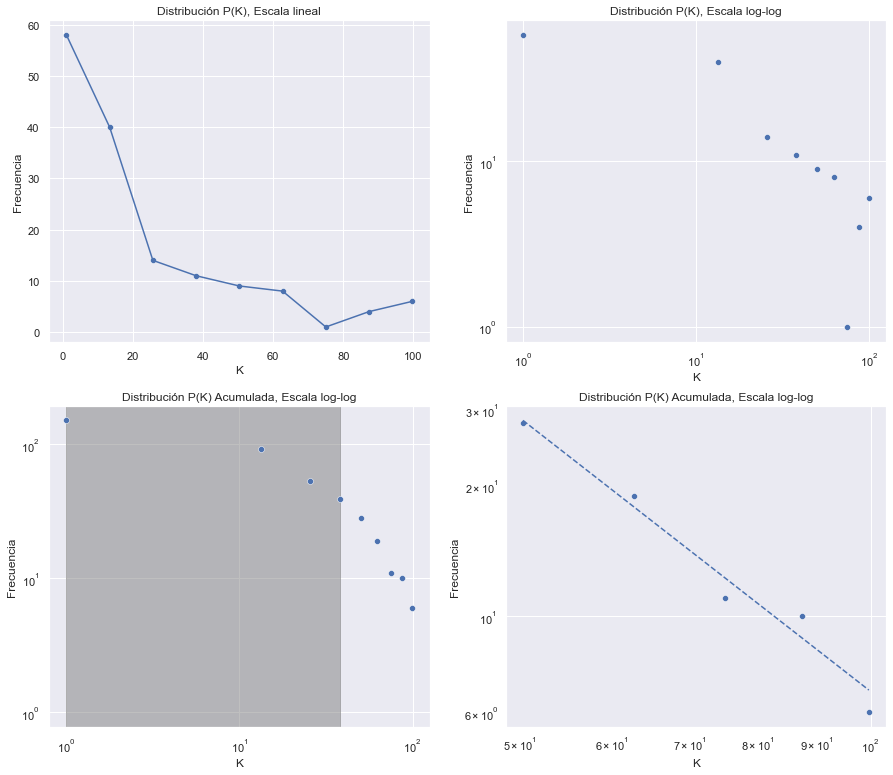

In [41]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,13))

axs = axs.flatten()

sns.scatterplot(x=x_deg, y=y_deg, ax=axs[0])
sns.lineplot(x=x_deg, y=y_deg, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_deg, y=y_deg, ax=axs[1])

axs[2].set(xscale="log", yscale="log")
axs[2].fill_between(x_deg, 0, 1, where= np.array(x_deg) < x_min,
                    color='grey', alpha=0.5, transform=axs[2].get_xaxis_transform())
sns.scatterplot(x=x_deg, y=y_deg_cum, ax=axs[2])

axs[3].set(xscale="log", yscale="log")
sns.scatterplot(x=x_deg_min, y=y_deg_cum_min, ax=axs[3])
axs[3].plot(x_deg_min, PWL(x_deg_min, *popt), '--')

for ax in axs:
    ax.set_xlabel(r"K")
    ax.set_ylabel(r"Frecuencia")
axs[0].set_title(r"Distribución P(K), Escala lineal")
axs[1].set_title(r"Distribución P(K), Escala log-log")
axs[2].set_title(r"Distribución P(K) Acumulada, Escala log-log")
axs[3].set_title(r"Distribución P(K) Acumulada, Escala log-log")


plt.show()

In [42]:
min_dmax = 1.3
for x_min in range(10, 80, 5):
    x_deg_min = [x_deg[i] for i in range(len(x_deg)) if x_deg[i] > x_min]
    y_deg_cum_min = [y_deg_cum[i] for i in range(len(x_deg)) if x_deg[i] > x_min]

    # now fit the curve to the powerlaw
    popt, pcov = curve_fit(PWL, x_deg_min, y_deg_cum_min, maxfev = 2000)
    D_max = np.max(np.abs(PWL(x_deg_min, *popt) - y_deg_cum_min))
    if min_dmax >= D_max:
        min_dmax = D_max
        print(x_min, D_max)

40 1.2687493802204273
45 1.2687493802204273
50 1.2687493802204273
75 1.0658141036401503e-14


C:\Users\Idols\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


#### Distribución de Fuerzas $P(S)$

In [43]:
# calculating the strength of each country
s_all = []
for c in countries:
    s = 0
    for n in H2.neighbors(c):
        s += H2.edges()[(c, n)]["weight"]
    s_all.append(s)

In [44]:
n_s_all = len(s_all)
r_s_all = np.max(s_all) - np.min(s_all)

iqr_s_all = np.percentile(s_all, 75) - np.percentile(s_all, 25)

#Freedman-Diaconis
a_s_all = 2*iqr_s_all*n_s_all**(-1/3)

k_s_all = int(np.round(r_s_all/a_s_all, 0))

hist_s_all, bin_edges_s_all = np.histogram(s_all, bins=k_s_all)

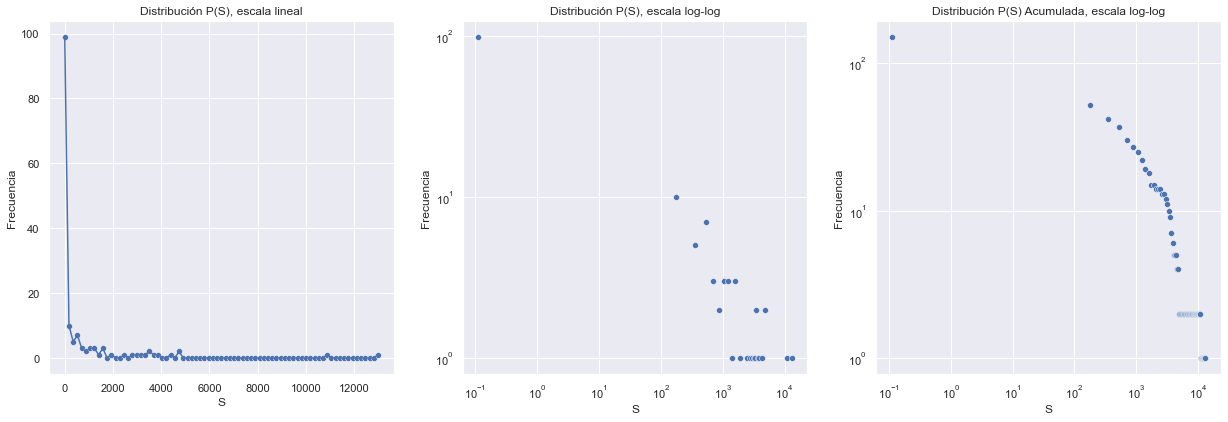

In [45]:
x_s_all = bin_edges_s_all[:len(hist_s_all)]
y_s_all = hist_s_all
y_s_all_cum = revcumsum(y_s_all)

sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6.5))

sns.scatterplot(x=x_s_all, y=y_s_all, ax=axs[0])
sns.lineplot(x=x_s_all, y=y_s_all, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_s_all, y=y_s_all, ax=axs[1])

axs[2].set(xscale="log", yscale="log")
sns.scatterplot(x=x_s_all, y=y_s_all_cum, ax=axs[2])

for ax in axs:
    ax.set_xlabel("S")
    ax.set_ylabel("Frecuencia")
axs[0].set_title("Distribución P(S), escala lineal")
axs[1].set_title("Distribución P(S), escala log-log")
axs[2].set_title("Distribución P(S) Acumulada, escala log-log")

plt.show()

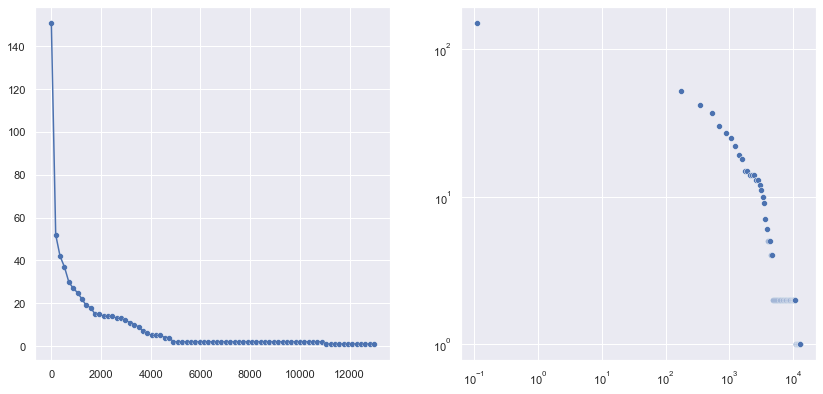

In [46]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(14,6.5))

sns.scatterplot(x=x_s_all, y=y_s_all_cum, ax=axs[0])
sns.lineplot(x=x_s_all, y=y_s_all_cum, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_s_all, y=y_s_all_cum, ax=axs[1])

plt.show()

In [47]:
# implicit function to evaluate a powerlaw function
#PWL = lambda x, xmin, alpha: ((alpha-1)/xmin) * ((x/xmin)**(-alpha))
PWL = lambda x, alpha, C: C*(np.power(x, -alpha))

x_min = 750

x_law = np.linspace(np.min(x_s_all), np.max(x_s_all), 1000)

# all the variables with min are used to get the range above x_min
x_law_min = [x_law[i] for i in range(len(x_law)) if x_law[i] > x_min]

x_s_all_min = [x_s_all[i] for i in range(len(x_s_all)) if x_s_all[i] > x_min]
y_s_all_cum_min = [y_s_all_cum[i] for i in range(len(x_s_all)) if x_s_all[i] > x_min]

# now fit the curve to the powerlaw
popt, pcov = curve_fit(PWL, x_s_all_min, y_s_all_cum_min, maxfev = 2000)
alpha, C = popt
perr = np.sqrt(np.diag(pcov))
alpha_err, C_err = perr

# Kolmogorov Smirnov
D_max = np.max(np.abs(PWL(x_s_all_min, *popt) - y_s_all_cum_min))

display(Latex(f"$\\alpha = %.3f \pm %.2f$" % (alpha, alpha_err)))
display(Latex(f"$C = %.1f \pm %.1f$" % (C, C_err)))
display(Latex(f"$f(x) = %.1f \cdot X^{{-%.3f}}$" % (C, alpha)))
display(Latex(f"$D = %.3f$" % D_max))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

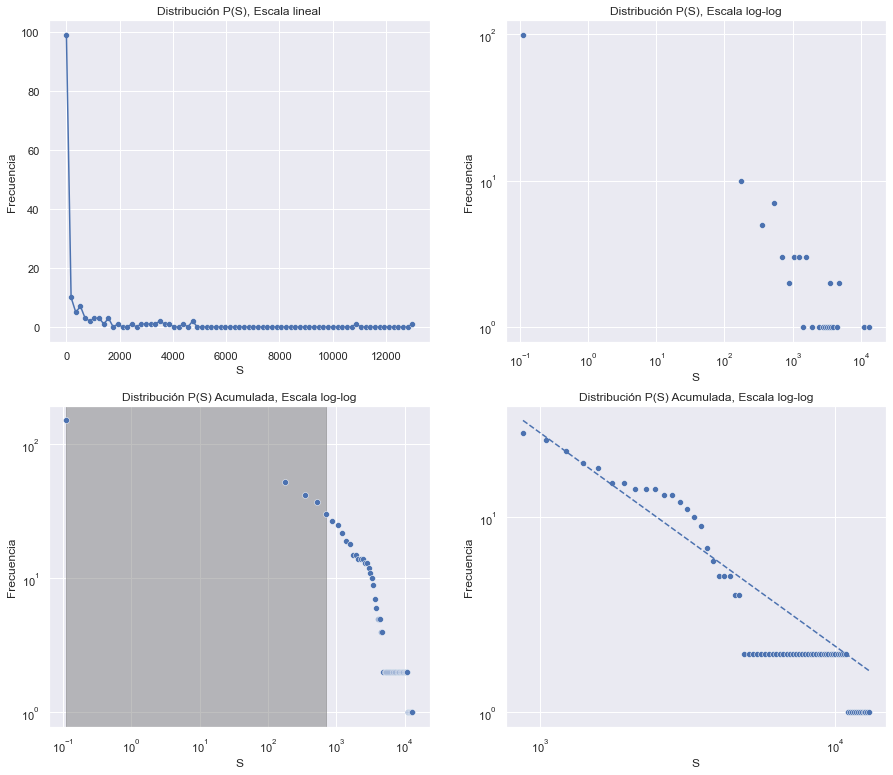

In [48]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,13))

axs = axs.flatten()

sns.scatterplot(x=x_s_all, y=y_s_all, ax=axs[0])
sns.lineplot(x=x_s_all, y=y_s_all, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_s_all, y=y_s_all, ax=axs[1])

axs[2].set(xscale="log", yscale="log")
axs[2].fill_between(x_s_all, 0, 1, where= np.array(x_s_all) < x_min,
                    color='grey', alpha=0.5, transform=axs[2].get_xaxis_transform())
sns.scatterplot(x=x_s_all, y=y_s_all_cum, ax=axs[2])

axs[3].set(xscale="log", yscale="log")
sns.scatterplot(x=x_s_all_min, y=y_s_all_cum_min, ax=axs[3])
axs[3].plot(x_s_all_min, PWL(x_s_all_min, *popt), '--')

for ax in axs:
    ax.set_xlabel(r"S")
    ax.set_ylabel(r"Frecuencia")
axs[0].set_title(r"Distribución P(S), Escala lineal")
axs[1].set_title(r"Distribución P(S), Escala log-log")
axs[2].set_title(r"Distribución P(S) Acumulada, Escala log-log")
axs[3].set_title(r"Distribución P(S) Acumulada, Escala log-log")

plt.show()

In [49]:
min_dmax = 6.0
for x_min in range(200, 1000, 10):
    x_s_all_min = [x_s_all[i] for i in range(len(x_s_all)) if x_s_all[i] > x_min]
    y_s_all_cum_min = [y_s_all_cum[i] for i in range(len(x_s_all)) if x_s_all[i] > x_min]

    # now fit the curve to the powerlaw
    popt, pcov = curve_fit(PWL, x_s_all_min, y_s_all_cum_min, maxfev = 2000)
    D_max = np.max(np.abs(PWL(x_s_all_min, *popt) - y_s_all_cum_min))
    if min_dmax >= D_max:
        min_dmax = D_max
        print(x_min, D_max)

360 5.12745323195842
370 5.12745323195842
380 5.12745323195842
390 5.12745323195842
400 5.12745323195842
410 5.12745323195842
420 5.12745323195842
430 5.12745323195842
440 5.12745323195842
450 5.12745323195842
460 5.12745323195842
470 5.12745323195842
480 5.12745323195842
490 5.12745323195842
500 5.12745323195842
510 5.12745323195842
520 5.12745323195842
710 4.386224038641256
720 4.386224038641256
730 4.386224038641256
740 4.386224038641256
750 4.386224038641256
760 4.386224038641256
770 4.386224038641256
780 4.386224038641256
790 4.386224038641256
800 4.386224038641256
810 4.386224038641256
820 4.386224038641256
830 4.386224038641256
840 4.386224038641256
850 4.386224038641256
860 4.386224038641256
870 4.386224038641256
880 4.117099133932928
890 4.117099133932928
900 4.117099133932928
910 4.117099133932928
920 4.117099133932928
930 4.117099133932928
940 4.117099133932928
950 4.117099133932928
960 4.117099133932928
970 4.117099133932928
980 4.117099133932928
990 4.117099133932928


#### Distribución de Pesos $P(w)$

In [50]:
H2_weights = []

for e in H2.edges():
    H2_weights.append(H2.edges()[e]["weight"])


<AxesSubplot:ylabel='Count'>

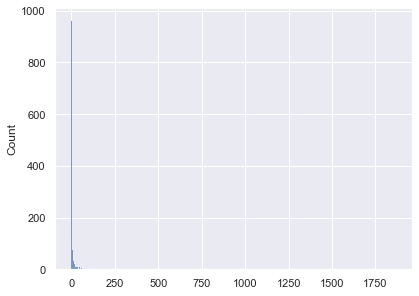

In [51]:
sns.histplot(x=H2_weights)

In [52]:
n_wei = len(H2_weights)
r_wei = np.max(H2_weights) - np.min(H2_weights)

iqr_wei = np.percentile(H2_weights, 75) - np.percentile(H2_weights, 25)

#Freedman-Diaconis
a_wei = 2*iqr_wei*n_wei**(-1/3)

k_wei = int(np.round(r_wei/a_wei, 0))

hist_wei, bin_edges_wei = np.histogram(H2_weights, bins=k_wei)

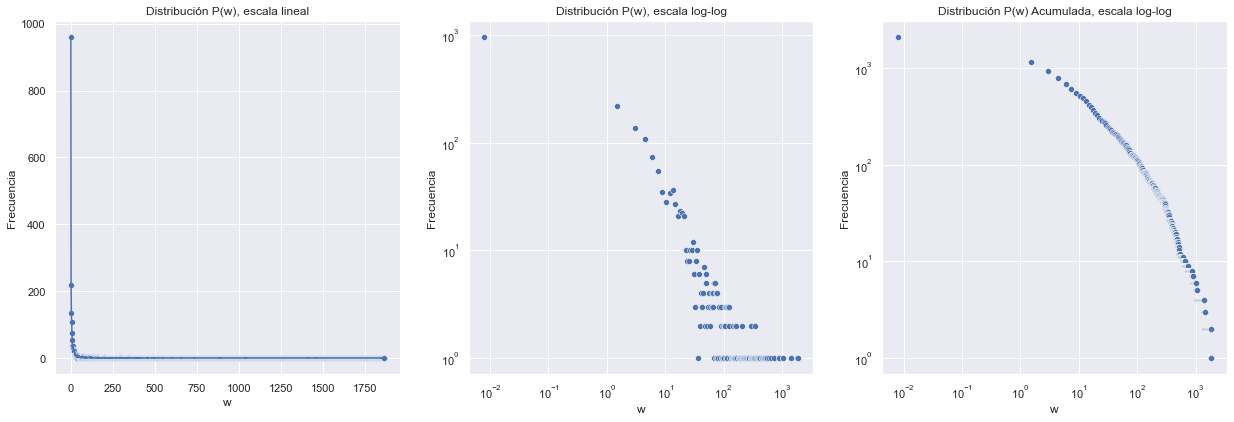

In [53]:
x_wei = bin_edges_wei[:len(hist_wei)]
y_wei = hist_wei
y_wei_cum = revcumsum(y_wei)

sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6.5))

sns.scatterplot(x=x_wei, y=y_wei, ax=axs[0])
sns.lineplot(x=x_wei, y=y_wei, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_wei, y=y_wei, ax=axs[1])

axs[2].set(xscale="log", yscale="log")
sns.scatterplot(x=x_wei, y=y_wei_cum, ax=axs[2])

for ax in axs:
    ax.set_xlabel("w")
    ax.set_ylabel("Frecuencia")
axs[0].set_title("Distribución P(w), escala lineal")
axs[1].set_title("Distribución P(w), escala log-log")
axs[2].set_title("Distribución P(w) Acumulada, escala log-log")

plt.show()

In [54]:
# implicit function to evaluate a powerlaw function
#PWL = lambda x, xmin, alpha: ((alpha-1)/xmin) * ((x/xmin)**(-alpha))
PWL = lambda x, alpha, C: C*(np.power(x, -alpha))

x_min = 260 # 2

x_law = np.linspace(np.min(x_wei), np.max(x_wei), 1000)

# all the variables with min are used to get the range above x_min
x_law_min = [x_law[i] for i in range(len(x_law)) if x_law[i] > x_min]

x_wei_min = [x_wei[i] for i in range(len(x_wei)) if x_wei[i] > x_min]
y_wei_cum_min = [y_wei_cum[i] for i in range(len(x_wei)) if x_wei[i] > x_min]

# now fit the curve to the powerlaw
popt, pcov = curve_fit(PWL, x_wei_min, y_wei_cum_min, maxfev = 2000)
alpha, C = popt
perr = np.sqrt(np.diag(pcov))
alpha_err, C_err = perr

# Kolmogorov Smirnov
D_max = np.max(np.abs(PWL(x_wei_min, *popt) - y_wei_cum_min))

display(Latex(f"$\\alpha = %.3f \pm %.2f$" % (alpha, alpha_err)))
display(Latex(f"$C = %.1f \pm %.1f$" % (C, C_err)))
display(Latex(f"$f(x) = %.1f \cdot X^{{-%.3f}}$" % (C, alpha)))
display(Latex(f"$D = %.3f$" % D_max))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

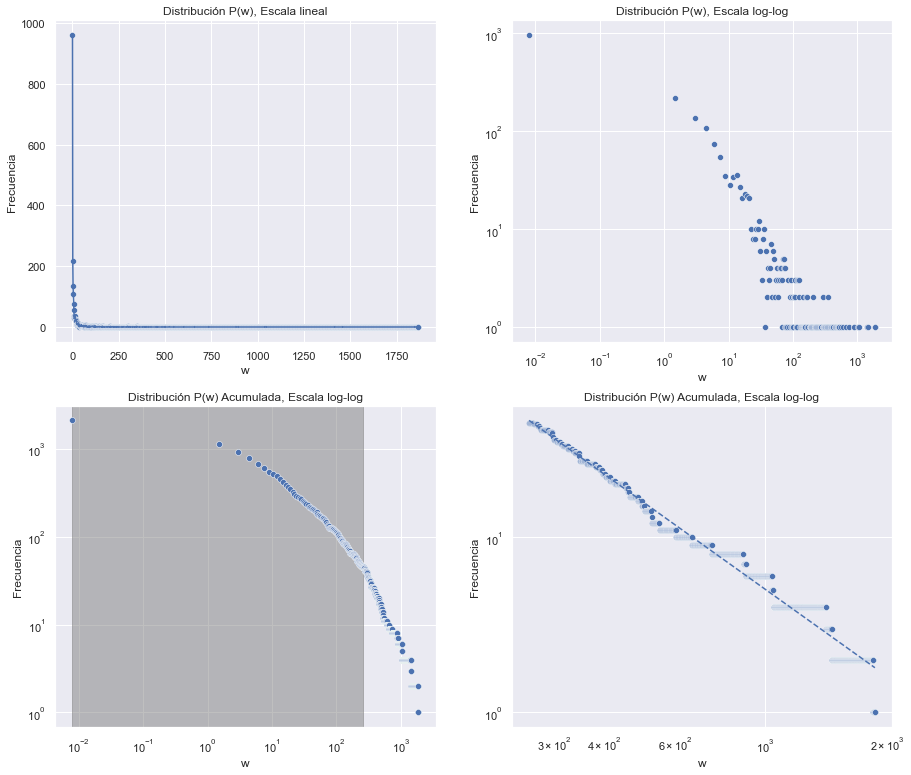

In [55]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,13))

axs = axs.flatten()

sns.scatterplot(x=x_wei, y=y_wei, ax=axs[0])
sns.lineplot(x=x_wei, y=y_wei, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_wei, y=y_wei, ax=axs[1])

axs[2].set(xscale="log", yscale="log")
axs[2].fill_between(x_wei, 0, 1, where= np.array(x_wei) < x_min,
                    color='grey', alpha=0.5, transform=axs[2].get_xaxis_transform())
sns.scatterplot(x=x_wei, y=y_wei_cum, ax=axs[2])

axs[3].set(xscale="log", yscale="log")
sns.scatterplot(x=x_wei_min, y=y_wei_cum_min, ax=axs[3])
axs[3].plot(x_wei_min, PWL(x_wei_min, *popt), '--')

for ax in axs:
    ax.set_xlabel(r"w")
    ax.set_ylabel(r"Frecuencia")
axs[0].set_title(r"Distribución P(w), Escala lineal")
axs[1].set_title(r"Distribución P(w), Escala log-log")
axs[2].set_title(r"Distribución P(w) Acumulada, Escala log-log")
axs[3].set_title(r"Distribución P(w) Acumulada, Escala log-log")

plt.show()

In [56]:
min_dmax = 22
for x_min in range(0, 500, 10):
    x_wei_min = [x_wei[i] for i in range(len(x_wei)) if x_wei[i] > x_min]
    y_wei_cum_min = [y_wei_cum[i] for i in range(len(x_wei)) if x_wei[i] > x_min]

    # now fit the curve to the powerlaw
    popt, pcov = curve_fit(PWL, x_wei_min, y_wei_cum_min, maxfev = 2000)
    D_max = np.max(np.abs(PWL(x_wei_min, *popt) - y_wei_cum_min))
    if min_dmax >= D_max:
        min_dmax = D_max
        print(x_min, D_max)

80 21.90403871846175
90 14.797655460423329
100 10.873769976411523
140 9.178209422944676
180 6.2241611834987225
200 6.0582174816811545
220 5.666330968219107
230 5.307151346558307
240 4.63938500412187
250 3.5401092151435947
260 2.5663554562151596
280 2.565731903491738
300 2.5189641616570633
310 2.5134448557336633
320 2.505451514686655
330 2.4836115869902624
340 2.4489702770632817
350 2.429876028610609
360 2.4277026707240914
370 2.415989735721075
380 2.363590013794555
390 2.301373036410057
400 2.245792021320339
410 2.206949628645427
420 2.158484495224794
460 1.784596126029335
470 1.7257656312083949
490 1.720261346504694


### Dispersión de Fuerza vs Grado ($S$ vs $K$)

In [57]:
x_disp_K = []
y_disp_S = []

for i in range(len(countries)):
    k = H2_degrees[i]
    s = s_all[i]
    if (s!=0) and (k!=0):
        x_disp_K.append(k)
        y_disp_S.append(s)

print("Total amount of countries ", len(countries))
print("Total amount of considered countries ", len(x_disp_K))

Total amount of countries  151
Total amount of considered countries  151


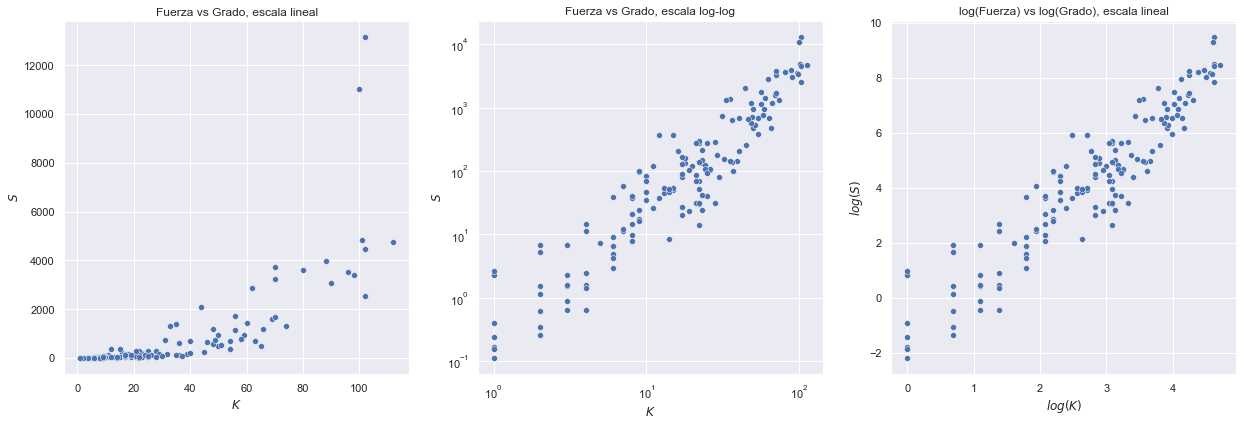

In [58]:
log_x_disp_K = np.log(x_disp_K)
log_y_disp_S = np.log(y_disp_S)

sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6.5))

sns.scatterplot(x=x_disp_K, y=y_disp_S, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_disp_K, y=y_disp_S, ax=axs[1])

sns.scatterplot(x=log_x_disp_K, y=log_y_disp_S, ax=axs[2])

for ax in axs:
    ax.set_xlabel(r"$K$")
    ax.set_ylabel(r"$S$")
axs[0].set_title(r"Fuerza vs Grado, escala lineal")
axs[1].set_title(r"Fuerza vs Grado, escala log-log")
axs[2].set_title(r"log(Fuerza) vs log(Grado), escala lineal")
ax.set_xlabel(r"$log(K)$")
ax.set_ylabel(r"$log(S)$")

plt.show()

In [59]:
x_fit = log_x_disp_K[:, np.newaxis]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_fit, log_y_disp_S)

# Make predictions using the testing set
y_pred = regr.predict(x_fit)

# The coefficients and intercept
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(log_y_disp_S, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(log_y_disp_S, y_pred))

Coefficients: 
 [2.01775051]
Intercept: 
 -1.3443964724316295
Mean squared error: 0.83
Coefficient of determination: 0.88


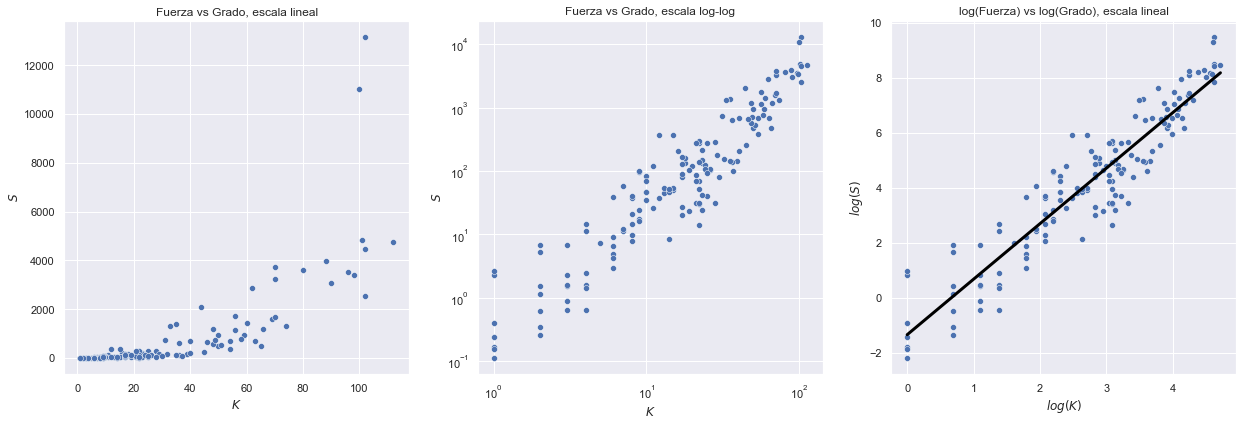

In [60]:
log_x_disp_K = np.log(x_disp_K)
log_y_disp_S = np.log(y_disp_S)

sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6.5))

sns.scatterplot(x=x_disp_K, y=y_disp_S, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_disp_K, y=y_disp_S, ax=axs[1])

sns.scatterplot(x=log_x_disp_K, y=log_y_disp_S, ax=axs[2])
sns.lineplot(x=x_fit[:,0], y=y_pred, linewidth=3, color="black", ax=axs[2])

for ax in axs:
    ax.set_xlabel(r"$K$")
    ax.set_ylabel(r"$S$")
axs[0].set_title(r"Fuerza vs Grado, escala lineal")
axs[1].set_title(r"Fuerza vs Grado, escala log-log")
axs[2].set_title(r"log(Fuerza) vs log(Grado), escala lineal")
ax.set_xlabel(r"$log(K)$")
ax.set_ylabel(r"$log(S)$")

plt.show()

### Índices de Clustering

#### Sin peso

In [61]:
no_weight = nx.clustering(H2)
np.mean(list(no_weight.values()))

0.7477557030117128

#### Con peso, Onnela et al (2005)

$$
\tilde c^w_i = \frac{1}{k_i \cdot (k_i - 1)} \cdot
\sum_{j,h} (\hat w_{i,j} \cdot \hat w_{i,h} \cdot \hat w_{j,h})
^{\frac{1}{3}}
$$

In [62]:
weighted_onn = nx.clustering(H2, weight="weight")
np.mean(list(weighted_onn.values()))

0.003031779210446067

#### Con peso, Berthelémy et al (2005)

$$
c_i^w = \frac{1}{s_i \cdot (k_i - 1)} \cdot
\sum_{j,h} \frac{w_{i,j} + w_{i,h}}{2} \cdot a_{i,j} \cdot a_{i,h} \cdot a_{j,h}
$$
Berthelémy et al (2005)

In [63]:
s_dicc = {countries[i]: s_all[i] for i in range(len(countries))}

def clustering_i(G, i, S):
    summatory = 0
    c_i = 0
    combs = list(combinations(list(G.neighbors(n)), 2))
    for j, h in combs:
        ij = (i, j) in G.edges()
        ih = (i, h) in G.edges()
        jh = (j, h) in G.edges()
        if ij and ih and jh:
            summatory += (G.edges()[(i, j)]["weight"] + G.edges()[(i, h)]["weight"])/2
    if summatory != 0:
        k_i = G.degree[i]
        c_i = summatory/(S[i]*(k_i - 1))
    return c_i

In [64]:
weighted_ber = {c: clustering_i(H2, c, s_dicc) for c in countries}
np.mean(list(weighted_ber.values()))

0.3696704443997844

## Pregunta 3

In [65]:
population = []

with open("cities.txt", "r") as cities:
    for c in cities:
        c = int(c.strip())
        population.append(c)
        
print(len(population))
print(np.mean(population))

19447
9002.05137039132


In [66]:
n_pop = len(population)
r_pop = np.max(population) - np.min(population)

iqr_pop = np.percentile(population, 75) - np.percentile(population, 25)

#Freedman-Diaconis
a_pop = 2*iqr_pop*n_pop**(-1/3)

k_pop = int(np.round(r_pop/a_pop, 0))

hist_pop, bin_edges_pop = np.histogram(population, bins=k_pop)

In [67]:
# the entries with cero are removed because the logarithm
x_pop = [bin_edges_pop[i] for i in range(len(hist_pop)) if hist_pop[i] > 0]
y_pop = [hist_pop[i] for i in range(len(hist_pop)) if hist_pop[i] > 0]
print(len(y_pop))
y_pop_cum = revcumsum(y_pop)

534


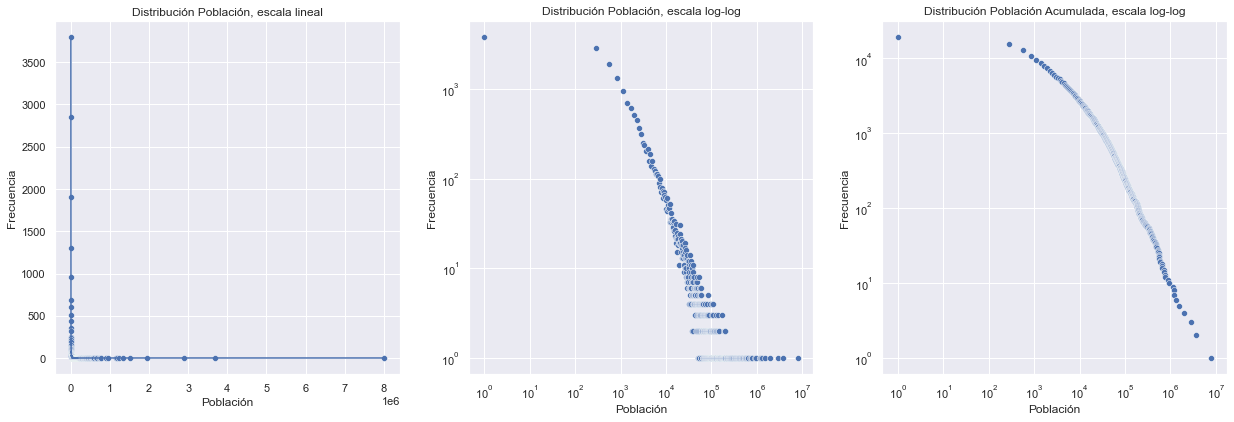

In [68]:
sns.set_theme()
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6.5))

sns.scatterplot(x=x_pop, y=y_pop, ax=axs[0])
sns.lineplot(x=x_pop, y=y_pop, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_pop, y=y_pop, ax=axs[1])

axs[2].set(xscale="log", yscale="log")
sns.scatterplot(x=x_pop, y=y_pop_cum, ax=axs[2])

for ax in axs:
    ax.set_xlabel("Población")
    ax.set_ylabel("Frecuencia")
axs[0].set_title("Distribución Población, escala lineal")
axs[1].set_title("Distribución Población, escala log-log")
axs[2].set_title("Distribución Población Acumulada, escala log-log")

plt.show()

### Cálculo de $\alpha$ con log-log

In [69]:
log_x_pop = np.log(x_pop)
log_y_pop = np.log(y_pop)

In [70]:
x_fit = log_x_pop[:, np.newaxis]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_fit, log_y_pop)

# Make predictions using the testing set
y_pred = regr.predict(x_fit)

# The coefficients and intercept
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(log_y_pop, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(log_y_pop, y_pred))

Coefficients: 
 [-1.01217399]
Intercept: 
 12.52348141569998
Mean squared error: 0.51
Coefficient of determination: 0.79


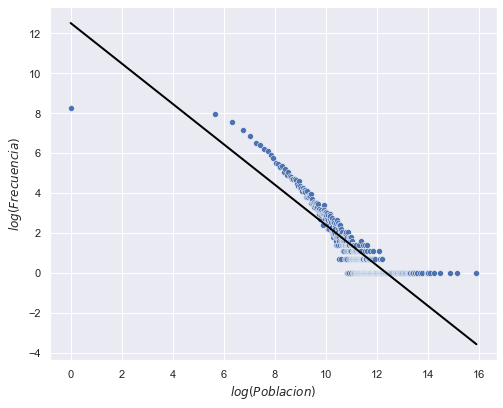

In [71]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(8,6.5))

sns.lineplot(x=x_fit[:,0], y=y_pred, linewidth=2, color="black", ax=axs)
sns.scatterplot(x=log_x_pop, y=log_y_pop, ax=axs)

axs.set_ylabel(r"$log(Frecuencia)$")
axs.set_xlabel(r"$log(Poblacion)$")

plt.show()

In [72]:
LIN = lambda x, m, n: -x*m + n

alpha = -regr.coef_[0]
log_C = regr.intercept_
C = np.power(np.e, log_C)

# Kolmogorov Smirnov entre las lineas
D_max = np.max(np.abs(PWL(x_pop, alpha, C) - y_pop))

D_max_log = np.max(np.abs(LIN(log_x_pop, alpha, log_C) - log_y_pop))

display(Latex(f"$log(f(x)) = log(C) - \\alpha \\cdot log(x)$"))
display(Latex(f"$log(f(x)) = %.2f - %.3f \\cdot log(x)$" % (log_C, alpha)))
display(Latex(f"$f(x) = %.1f \cdot X^{{-%.3f}}$" % (C, alpha)))
display(Latex(f"$D = %.3f$" % D_max))
display(Latex(f"$D_{{log}} = %.3f$" % D_max_log))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Cálculo de $\alpha$ con binning exponencial

In [73]:
k_exp_pop = int(np.ceil(np.log2(k_pop)))
start_exp = np.log2(int(np.min(x_pop)))
stop_exp = np.log2(int(np.max(x_pop)))

bins = np.logspace(start_exp, stop_exp, k_exp_pop, base=2)

y_exp_pop = np.zeros(len(bins))

for i in range(len(x_pop)):
    curr_x = x_pop[i]
    for j in range(len(bins)):
        if bins[j] >= curr_x:
            y_exp_pop[j] += y_pop[i]
            break

In [74]:
# implicit function to evaluate a powerlaw function
#PWL = lambda x, xmin, alpha: ((alpha-1)/xmin) * ((x/xmin)**(-alpha))
PWL = lambda x, alpha, C: C*(np.power(x, -alpha))

x_min = 1

x_law = np.linspace(np.min(bins), np.max(bins), 1000)

# all the variables with min are used to get the range above x_min
x_law_min = [x_law[i] for i in range(len(x_law)) if x_law[i] > x_min]

bins_min = [bins[i] for i in range(len(bins)) if bins[i] > x_min]
y_exp_pop_min = [y_exp_pop[i] for i in range(len(bins)) if bins[i] > x_min]

# now fit the curve to the powerlaw
popt, pcov = curve_fit(PWL, bins_min, y_exp_pop_min, maxfev = 2000)
alpha, C = popt
perr = np.sqrt(np.diag(pcov))
alpha_err, C_err = perr

# Kolmogorov Smirnov
D_max = np.max(np.abs(PWL(bins_min, *popt) - y_exp_pop_min))

display(Latex(f"$\\alpha = %.3f \pm %.2f$" % (alpha, alpha_err)))
display(Latex(f"$C = %.1f \pm %.1f$" % (C, C_err)))
display(Latex(f"$f(x) = %.1f \cdot X^{{-%.3f}}$" % (C, alpha)))
display(Latex(f"$D = %.3f$" % D_max))

<ipython-input-74-950fc1ab8b3c>:3: RuntimeWarning: overflow encountered in power
  PWL = lambda x, alpha, C: C*(np.power(x, -alpha))
<ipython-input-74-950fc1ab8b3c>:3: RuntimeWarning: overflow encountered in multiply
  PWL = lambda x, alpha, C: C*(np.power(x, -alpha))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

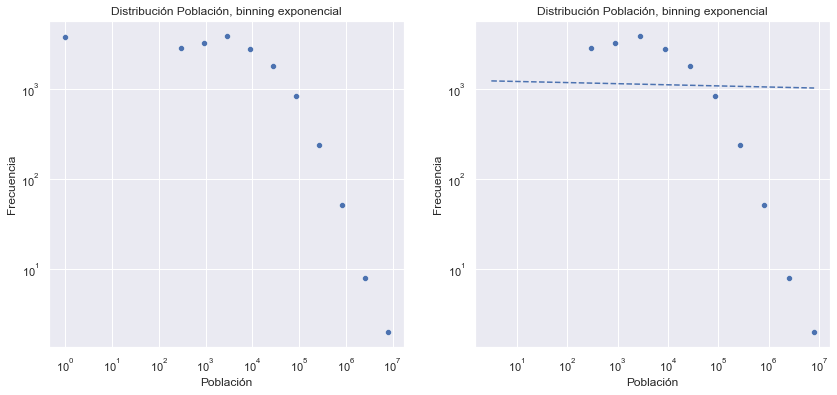

In [75]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(14,6))

axs[0].fill_between(bins, 0, 1, where= np.array(bins) < x_min,
                    color='grey', alpha=0.5, transform=axs[0].get_xaxis_transform())
sns.scatterplot(x=bins, y=y_exp_pop, ax=axs[0])
axs[0].set(xscale="log", yscale="log")

sns.scatterplot(x=bins_min, y=y_exp_pop_min, ax=axs[1])
axs[1].plot(bins_min, PWL(bins_min, *popt), '--')
axs[1].set(xscale="log", yscale="log")

for ax in axs:
    ax.set_ylabel("Frecuencia")
    ax.set_xlabel("Población")
    ax.set_title("Distribución Población, binning exponencial")

plt.show()

#### Utilizando $X_{min}$

In [76]:
# implicit function to evaluate a powerlaw function
#PWL = lambda x, xmin, alpha: ((alpha-1)/xmin) * ((x/xmin)**(-alpha))
PWL = lambda x, alpha, C: C*(np.power(x, -alpha))

x_min = 27500

x_law = np.linspace(np.min(bins), np.max(bins), 1000)

# all the variables with min are used to get the range above x_min
x_law_min = [x_law[i] for i in range(len(x_law)) if x_law[i] > x_min]

bins_min = [bins[i] for i in range(len(bins)) if bins[i] > x_min]
y_exp_pop_min = [y_exp_pop[i] for i in range(len(bins)) if bins[i] > x_min]

# now fit the curve to the powerlaw
popt, pcov = curve_fit(PWL, bins_min, y_exp_pop_min, maxfev = 2000)
alpha, C = popt
perr = np.sqrt(np.diag(pcov))
alpha_err, C_err = perr

# Kolmogorov Smirnov
D_max = np.max(np.abs(PWL(bins_min, *popt) - y_exp_pop_min))

display(Latex(f"$\\alpha = %.3f \pm %.2f$" % (alpha, alpha_err)))
display(Latex(f"$C = %.1f \pm %.1f$" % (C, C_err)))
display(Latex(f"$f(x) = %.1f \cdot X^{{-%.3f}}$" % (C, alpha)))
display(Latex(f"$D = %.3f$" % D_max))

<ipython-input-76-222a872f2fed>:3: RuntimeWarning: overflow encountered in power
  PWL = lambda x, alpha, C: C*(np.power(x, -alpha))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

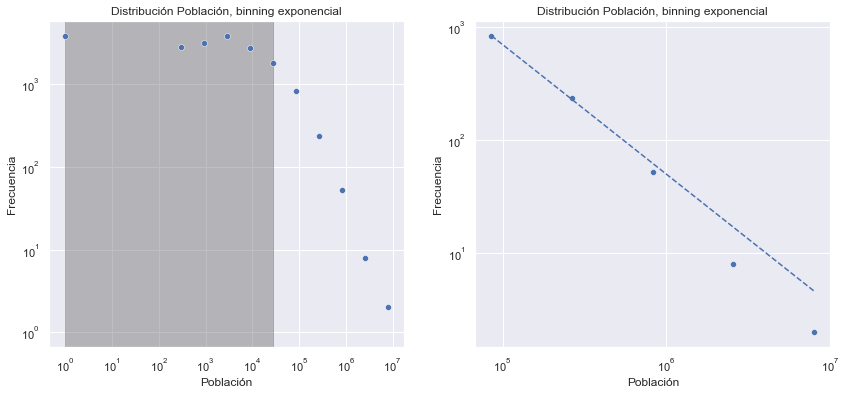

In [77]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(14,6))

axs[0].fill_between(bins, 0, 1, where= np.array(bins) < x_min,
                    color='grey', alpha=0.5, transform=axs[0].get_xaxis_transform())
sns.scatterplot(x=bins, y=y_exp_pop, ax=axs[0])
axs[0].set(xscale="log", yscale="log")

sns.scatterplot(x=bins_min, y=y_exp_pop_min, ax=axs[1])
axs[1].plot(bins_min, PWL(bins_min, *popt), '--')
axs[1].set(xscale="log", yscale="log")

for ax in axs:
    ax.set_ylabel("Frecuencia")
    ax.set_xlabel("Población")
    ax.set_title("Distribución Población, binning exponencial")

plt.show()

In [78]:
min_dmax = 2754
for x_min in range(100, 50000, 100):
    bins_min = [bins[i] for i in range(len(bins)) if bins[i] > x_min]
    y_exp_pop_min = [y_exp_pop[i] for i in range(len(bins)) if bins[i] > x_min]

    # now fit the curve to the powerlaw
    popt, pcov = curve_fit(PWL, bins_min, y_exp_pop_min, maxfev = 2000)
    D_max = np.max(np.abs(PWL(bins_min, *popt) - y_exp_pop_min))
    if min_dmax > D_max:
        min_dmax = D_max
        print(x_min, D_max)

<ipython-input-76-222a872f2fed>:3: RuntimeWarning: overflow encountered in power
  PWL = lambda x, alpha, C: C*(np.power(x, -alpha))


100 1465.8704174485883
300 965.2205449254961
1000 310.81347178107785
2900 274.01259483964077
8900 100.75073759984014
27500 10.356412889656298


### Cálculo de $\alpha$ con distribución acumulada

In [79]:
# implicit function to evaluate a powerlaw function
#PWL = lambda x, xmin, alpha: ((alpha-1)/xmin) * ((x/xmin)**(-alpha))
PWL = lambda x, alpha, C: C*(np.power(x, -alpha))

x_min = 1 # 2

x_law = np.linspace(np.min(x_pop), np.max(x_pop), 1000)

# all the variables with min are used to get the range above x_min
x_law_min = [x_law[i] for i in range(len(x_law)) if x_law[i] > x_min]

x_pop_min = [x_pop[i] for i in range(len(x_pop)) if x_pop[i] > x_min]
y_pop_cum_min = [y_pop_cum[i] for i in range(len(x_pop)) if x_pop[i] > x_min]

# now fit the curve to the powerlaw
popt, pcov = curve_fit(PWL, x_pop_min, y_pop_cum_min, maxfev = 2000)
alpha, C = popt
perr = np.sqrt(np.diag(pcov))
alpha_err, C_err = perr

# Kolmogorov Smirnov
D_max = np.max(np.abs(PWL(x_pop_min, *popt) - y_pop_cum_min))

display(Latex(f"$\\alpha = %.3f \pm %.2f$" % (alpha, alpha_err)))
display(Latex(f"$C = %.1f \pm %.1f$" % (C, C_err)))
display(Latex(f"$f(x) = %.1f \cdot X^{{-%.3f}}$" % (C, alpha)))
display(Latex(f"$D = %.3f$" % D_max))

<ipython-input-79-0db3a9d050f9>:3: RuntimeWarning: overflow encountered in power
  PWL = lambda x, alpha, C: C*(np.power(x, -alpha))
<ipython-input-79-0db3a9d050f9>:3: RuntimeWarning: overflow encountered in multiply
  PWL = lambda x, alpha, C: C*(np.power(x, -alpha))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

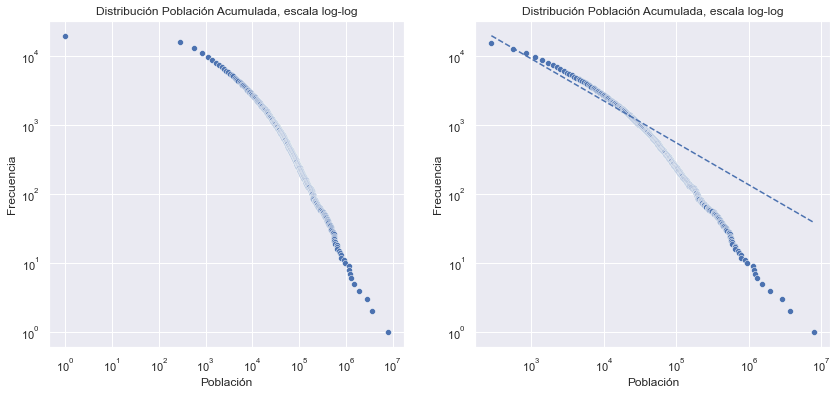

In [80]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(14,6))

axs[0].fill_between(x_pop, 0, 1, where= np.array(x_pop) < x_min,
                    color='grey', alpha=0.5, transform=axs[0].get_xaxis_transform())
sns.scatterplot(x=x_pop, y=y_pop_cum, ax=axs[0])
axs[0].set(xscale="log", yscale="log")

sns.scatterplot(x=x_pop_min, y=y_pop_cum_min, ax=axs[1])
axs[1].plot(x_pop_min, PWL(x_pop_min, *popt), '--')
axs[1].set(xscale="log", yscale="log")

for ax in axs:
    ax.set_ylabel("Frecuencia")
    ax.set_xlabel("Población")
    ax.set_title("Distribución Población Acumulada, escala log-log")

plt.show()

#### Utilizando $X_{min}$

In [81]:
# implicit function to evaluate a powerlaw function
#PWL = lambda x, xmin, alpha: ((alpha-1)/xmin) * ((x/xmin)**(-alpha))
PWL = lambda x, alpha, C: C*(np.power(x, -alpha))

x_min = 49900 # 2

x_law = np.linspace(np.min(x_pop), np.max(x_pop), 1000)

# all the variables with min are used to get the range above x_min
x_law_min = [x_law[i] for i in range(len(x_law)) if x_law[i] > x_min]

x_pop_min = [x_pop[i] for i in range(len(x_pop)) if x_pop[i] > x_min]
y_pop_cum_min = [y_pop_cum[i] for i in range(len(x_pop)) if x_pop[i] > x_min]

# now fit the curve to the powerlaw
popt, pcov = curve_fit(PWL, x_pop_min, y_pop_cum_min, maxfev = 2000)
alpha, C = popt
perr = np.sqrt(np.diag(pcov))
alpha_err, C_err = perr

# Kolmogorov Smirnov
D_max = np.max(np.abs(PWL(x_pop_min, *popt) - y_pop_cum_min))

display(Latex(f"$\\alpha = %.3f \pm %.3f$" % (alpha, alpha_err)))
display(Latex(f"$C = %.1f \pm %.1f$" % (C, C_err)))
display(Latex(f"$f(x) = %.1f \cdot X^{{-%.3f}}$" % (C, alpha)))
display(Latex(f"$D = %.3f$" % D_max))

<ipython-input-81-b494b4792aa0>:3: RuntimeWarning: overflow encountered in power
  PWL = lambda x, alpha, C: C*(np.power(x, -alpha))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

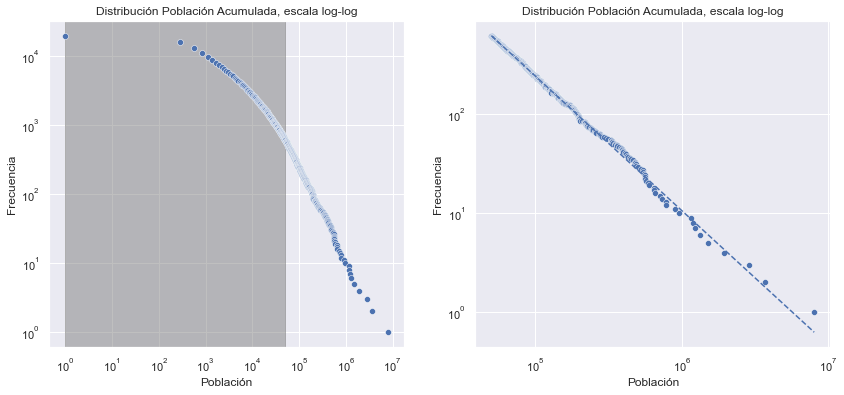

In [82]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(14,6))

axs[0].fill_between(x_pop, 0, 1, where= np.array(x_pop) < x_min,
                    color='grey', alpha=0.5, transform=axs[0].get_xaxis_transform())
sns.scatterplot(x=x_pop, y=y_pop_cum, ax=axs[0])
axs[0].set(xscale="log", yscale="log")

sns.scatterplot(x=x_pop_min, y=y_pop_cum_min, ax=axs[1])
axs[1].plot(x_pop_min, PWL(x_pop_min, *popt), '--')
axs[1].set(xscale="log", yscale="log")

for ax in axs:
    ax.set_ylabel("Frecuencia")
    ax.set_xlabel("Población")
    ax.set_title("Distribución Población Acumulada, escala log-log")

plt.show()

In [83]:
min_dmax = 3996
for x_min in range(100, 51000, 100):
    x_pop_min = [x_pop[i] for i in range(len(x_pop)) if x_pop[i] > x_min]
    y_pop_cum_min = [y_pop_cum[i] for i in range(len(x_pop)) if x_pop[i] > x_min]

    # now fit the curve to the powerlaw
    popt, pcov = curve_fit(PWL, x_pop_min, y_pop_cum_min, maxfev = 2000)
    D_max = np.max(np.abs(PWL(x_pop_min, *popt) - y_pop_cum_min))
    if min_dmax > D_max:
        min_dmax = D_max
        print(x_min, D_max)

<ipython-input-81-b494b4792aa0>:3: RuntimeWarning: overflow encountered in power
  PWL = lambda x, alpha, C: C*(np.power(x, -alpha))
<ipython-input-81-b494b4792aa0>:3: RuntimeWarning: overflow encountered in multiply
  PWL = lambda x, alpha, C: C*(np.power(x, -alpha))


300 2686.501041687243
600 2104.9123494490123
900 1759.9747530784116
1200 1524.0043882234822
1500 1297.403147345376
1700 1165.0550150795461
2000 1066.3219962095964
2300 1001.2325707289492
2600 930.627745488674
2900 873.2869011720641
3100 791.0730182494617
3400 732.561409693938
3700 670.4391210915319
4000 639.755830016552
4300 578.3570032611979
4500 560.690951928138
4800 512.3890745953086
5100 494.28737664299933
5400 461.9334296021643
5700 432.99793620640867
5900 406.47535844851063
6200 386.45131860689753
6500 376.53122991546843
6800 368.74617666903896
7100 349.3992949894068
7300 327.69599245301333
7900 310.3867223256034
8200 302.936430540778
8500 293.09128262537706
8700 276.2491923430571
9000 271.51619181200704
9300 265.5595655263792
9600 260.97152104334873
9900 254.58743704780272
10100 239.0310098145128
10700 226.76154339612958
11000 217.91056038516763
11300 216.00805284960688
11500 212.38314245471565
11800 210.76992220628654
12100 197.1677512405954
12700 195.50085897045847
12900 194.5

## Pregunta 4

In [84]:
def check_avalancha(G, n, lost_rate=1/1000):
    m = G.nodes()[n]["max"]
    b = G.nodes()[n]["balde"]
    size = 0
    if b > m:
        size += 1
        G.nodes()[n]["balde"] = 1
        neighbors = list(G.neighbors(n))
        for neigh in neighbors:
            if random.random() > lost_rate:
                G.nodes()[neigh]["balde"] += 1
                size += check_avalancha(G, neigh, lost_rate)
    return size

def experiment4(G, lost_rate=1/1000):
    results = []
    for i in range(10000):
        test = random.randint(0, 999)
        G.nodes()[test]["balde"] += 1
        result = check_avalancha(G, test, lost_rate=lost_rate)
        results.append(result)
    return results

### Erdös-Rényi

Para utilizar la función de Networkx se requiere el número de nodos y arcos, así que se calcula el número de arcos como: $Arcos = n^2p/2$

Lo anterior se calcula teniendo en cuenta que $np \approx <k>$ y que $<k> = \sum k_i/n$, con esto se obtiene la suma total de grados del grafo $\sum k_i = n^2 p$, pero como queremos el número de arco y no de grados, se divide por dos.

In [85]:
n = 1000  # nodes
avg_k = 2
p = avg_k/n # probability 
m = 0.5*p*n**2  # edges
seed = 20161  # seed random number generators for reproducibility

ER = nx.gnm_random_graph(n, m, seed=seed)

In [86]:
random.seed(83)

ER_deg = ER.degree()

#initialize everything
for i in range(1000):
    max_cap = ER_deg[i]
    ER.nodes()[i]["max"] = max_cap
    ER.nodes()[i]["balde"] = random.randint(0,max_cap)

In [87]:
ER_sizes = experiment4(ER, lost_rate=1/400)

<AxesSubplot:ylabel='Count'>

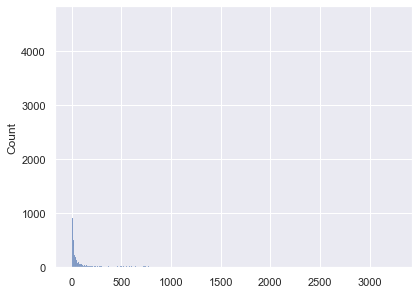

In [88]:
sns.histplot(x=ER_sizes)

#### Gráfica ER

In [89]:
n_ER = len(ER_sizes)
r_ER = np.max(ER_sizes) - np.min(ER_sizes)

iqr_ER = np.percentile(ER_sizes, 75) - np.percentile(ER_sizes, 25)

#Freedman-Diaconis
a_ER = 2*iqr_ER*n_ER**(-1/3)

k_ER = int(np.round(r_ER/a_ER, 0))

hist_ER, bin_edges_ER = np.histogram(ER_sizes, bins=k_ER)

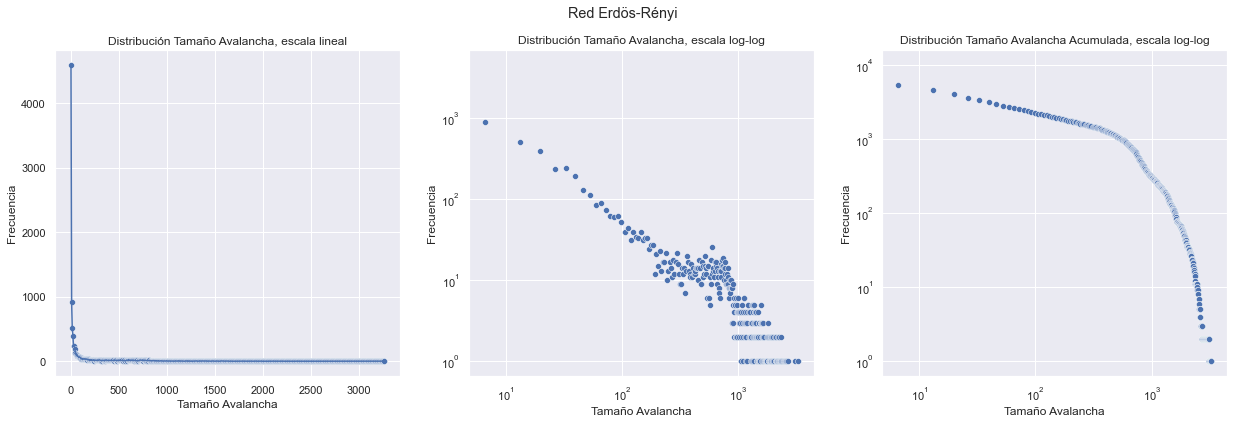

In [90]:
x_ER = bin_edges_ER[:len(hist_ER)]
y_ER = hist_ER
y_ER_cum = revcumsum(y_ER)

sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6))

sns.scatterplot(x=x_ER, y=y_ER, ax=axs[0])
sns.lineplot(x=x_ER, y=y_ER, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_ER, y=y_ER, ax=axs[1])

axs[2].set(xscale="log", yscale="log")
sns.scatterplot(x=x_ER, y=y_ER_cum, ax=axs[2])

for ax in axs:
    ax.set_xlabel("Tamaño Avalancha")
    ax.set_ylabel("Frecuencia")
axs[0].set_title("Distribución Tamaño Avalancha, escala lineal")
axs[1].set_title("Distribución Tamaño Avalancha, escala log-log")
axs[2].set_title("Distribución Tamaño Avalancha Acumulada, escala log-log")
fig.suptitle("Red Erdös-Rényi")

plt.show()

#### Ajuste ER con acumulada

In [91]:
# implicit function to evaluate a powerlaw function
#PWL = lambda x, xmin, alpha: ((alpha-1)/xmin) * ((x/xmin)**(-alpha))
PWL = lambda x, alpha, C: C*(np.power(x, -alpha))

x_min = 1330

x_law = np.linspace(np.min(x_ER), np.max(x_ER), 1000)

# all the variables with min are used to get the range above x_min
x_law_min = [x_law[i] for i in range(len(x_law)) if x_law[i] > x_min]

x_ER_min = [x_ER[i] for i in range(len(x_ER)) if x_ER[i] > x_min]
y_ER_cum_min = [y_ER_cum[i] for i in range(len(x_ER)) if x_ER[i] > x_min]

# now fit the curve to the powerlaw
popt, pcov = curve_fit(PWL, x_ER_min, y_ER_cum_min, maxfev = 2000)
alpha, C = popt
perr = np.sqrt(np.diag(pcov))
alpha_err, C_err = perr

# Kolmogorov Smirnov
D_max = np.max(np.abs(PWL(x_ER_min, *popt) - y_ER_cum_min))

display(Latex(f"$\\alpha = %.3f \pm %.2f$" % (alpha, alpha_err)))
display(Latex(f"$C = %.1f \pm %.1f$" % (C, C_err)))
display(Latex(f"$f(x) = %.1f \cdot X^{{-%.3f}}$" % (C, alpha)))
display(Latex(f"$D = %.3f$" % D_max))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

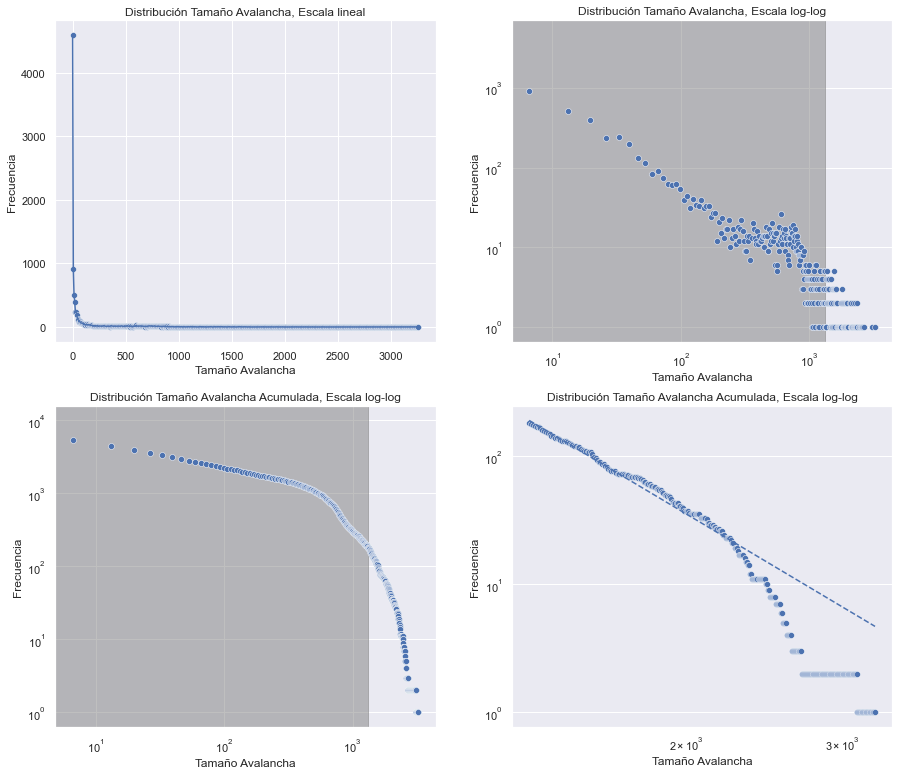

In [92]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,13))

axs = axs.flatten()

sns.scatterplot(x=x_ER, y=y_ER, ax=axs[0])
sns.lineplot(x=x_ER, y=y_ER, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
axs[1].fill_between(x_ER, 0, 1, where= np.array(x_ER) < x_min,
                    color='grey', alpha=0.5, transform=axs[1].get_xaxis_transform())
sns.scatterplot(x=x_ER, y=y_ER, ax=axs[1])

axs[2].set(xscale="log", yscale="log")
axs[2].fill_between(x_ER, 0, 1, where= np.array(x_ER) < x_min,
                    color='grey', alpha=0.5, transform=axs[2].get_xaxis_transform())
sns.scatterplot(x=x_ER, y=y_ER_cum, ax=axs[2])

axs[3].set(xscale="log", yscale="log")
sns.scatterplot(x=x_ER_min, y=y_ER_cum_min, ax=axs[3])
axs[3].plot(x_ER_min, PWL(x_ER_min, *popt), '--')

for ax in axs:
    ax.set_xlabel(r"Tamaño Avalancha")
    ax.set_ylabel(r"Frecuencia")
axs[0].set_title(r"Distribución Tamaño Avalancha, Escala lineal")
axs[1].set_title(r"Distribución Tamaño Avalancha, Escala log-log")
axs[2].set_title(r"Distribución Tamaño Avalancha Acumulada, Escala log-log")
axs[3].set_title(r"Distribución Tamaño Avalancha Acumulada, Escala log-log")


plt.show()

In [93]:
min_dmax = 37.1
for x_min in range(10, 2000, 10):
    x_ER_min = [x_ER[i] for i in range(len(x_ER)) if x_ER[i] > x_min]
    y_ER_cum_min = [y_ER_cum[i] for i in range(len(x_ER)) if x_ER[i] > x_min]

    # now fit the curve to the powerlaw
    popt, pcov = curve_fit(PWL, x_ER_min, y_ER_cum_min, maxfev = 2000)
    D_max = np.max(np.abs(PWL(x_ER_min, *popt) - y_ER_cum_min))
    if min_dmax >= D_max:
        min_dmax = D_max
        print(x_min, D_max)

680 36.840910592541434
1110 33.90867853710307
1170 33.25724922433358
1180 29.22428544397195
1190 27.060702455090023
1230 25.875842727624615
1250 23.24142131187324
1260 21.42353019157386
1270 18.439677032449936
1280 17.164438739749073
1290 15.07583861427517
1300 13.638157904916227
1320 11.575362822744808
1330 9.48989609744632
1350 8.900813139535984
1360 8.886161257748618
1370 8.876311163629786
1460 8.222378335147027
1470 8.100540294403665
1490 7.870618039822901
1500 7.788499254070302
1510 7.673919639496731
1520 7.654237495574442
1530 7.620025074013284
1760 6.582963214832176
1770 5.94574966815156
1780 5.901225744478477
1830 5.630459141573464
1840 5.530993539060908
1850 5.484918544859767
1860 5.369854642270827
1870 5.310969136929419
1880 5.191876948189034
1890 5.1168021512432595
1900 4.961477107736211


#### Ajuste ER sin acumulada

In [94]:
# implicit function to evaluate a powerlaw function
#PWL = lambda x, xmin, alpha: ((alpha-1)/xmin) * ((x/xmin)**(-alpha))
PWL = lambda x, alpha, C: C*(np.power(x, -alpha))

x_min = 20

x_law = np.linspace(np.min(x_ER), np.max(x_ER), 1000)

# all the variables with min are used to get the range above x_min
x_law_min = [x_law[i] for i in range(len(x_law)) if x_law[i] > x_min]

x_ER_min = [x_ER[i] for i in range(len(x_ER)) if x_ER[i] > x_min]
y_ER_min = [y_ER[i] for i in range(len(x_ER)) if x_ER[i] > x_min]

# now fit the curve to the powerlaw
popt, pcov = curve_fit(PWL, x_ER_min, y_ER_min, maxfev = 2000)
alpha, C = popt
perr = np.sqrt(np.diag(pcov))
alpha_err, C_err = perr

# Kolmogorov Smirnov
D_max = np.max(np.abs(PWL(x_ER_min, *popt) - y_ER_min))

display(Latex(f"$\\alpha = %.3f \pm %.2f$" % (alpha, alpha_err)))
display(Latex(f"$C = %.1f \pm %.1f$" % (C, C_err)))
display(Latex(f"$f(x) = %.1f \cdot X^{{-%.3f}}$" % (C, alpha)))
display(Latex(f"$D = %.3f$" % D_max))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

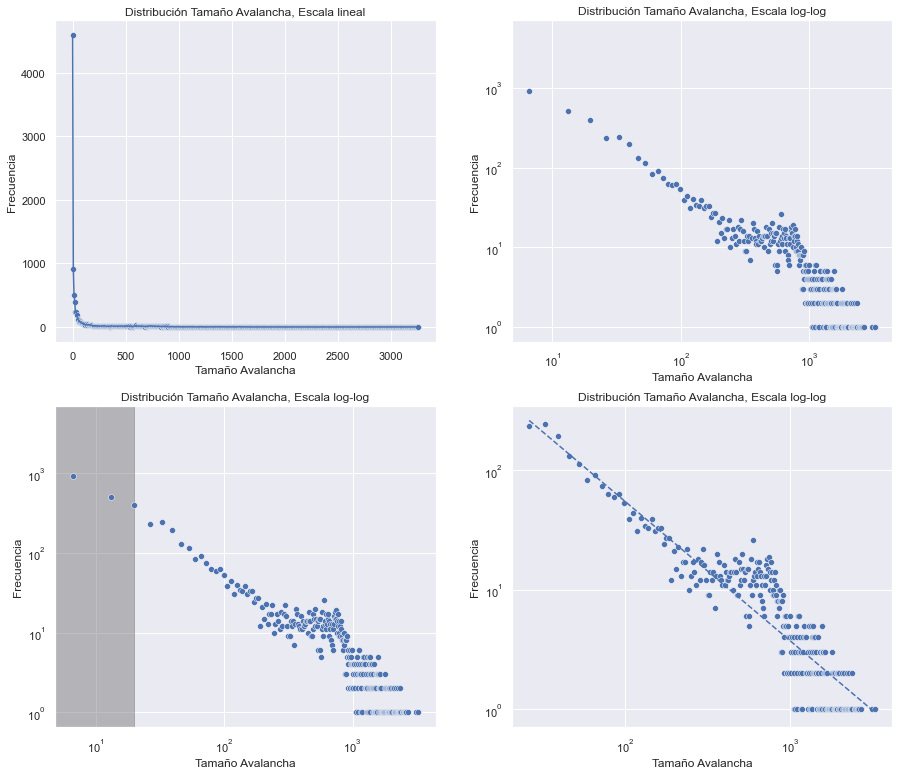

In [95]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,13))

axs = axs.flatten()

sns.scatterplot(x=x_ER, y=y_ER, ax=axs[0])
sns.lineplot(x=x_ER, y=y_ER, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_ER, y=y_ER, ax=axs[1])

axs[2].set(xscale="log", yscale="log")
axs[2].fill_between(x_ER, 0, 1, where= np.array(x_ER) < x_min,
                    color='grey', alpha=0.5, transform=axs[2].get_xaxis_transform())
sns.scatterplot(x=x_ER, y=y_ER, ax=axs[2])

axs[3].set(xscale="log", yscale="log")
sns.scatterplot(x=x_ER_min, y=y_ER_min, ax=axs[3])
axs[3].plot(x_ER_min, PWL(x_ER_min, *popt), '--')

for ax in axs:
    ax.set_xlabel(r"Tamaño Avalancha")
    ax.set_ylabel(r"Frecuencia")
    ax.set_title(r"Distribución Tamaño Avalancha, Escala log-log")
axs[0].set_title(r"Distribución Tamaño Avalancha, Escala lineal")


plt.show()

In [96]:
min_dmax = 100
for x_min in range(10, 2000, 10):
    x_ER_min = [x_ER[i] for i in range(len(x_ER)) if x_ER[i] > x_min]
    y_ER_min = [y_ER[i] for i in range(len(x_ER)) if x_ER[i] > x_min]

    # now fit the curve to the powerlaw
    popt, pcov = curve_fit(PWL, x_ER_min, y_ER_min, maxfev = 2000)
    D_max = np.max(np.abs(PWL(x_ER_min, *popt) - y_ER_min))
    if min_dmax >= D_max:
        min_dmax = D_max
        print(x_min, D_max)

10 49.97969232682124
20 40.555175568274535
30 22.443625047452073
40 18.748638055169742
50 18.611686369384884
60 18.517532967275375
70 18.402445490083764
80 18.366685065968277
90 18.354422772165613
100 18.30536399906512
200 18.24291628277743
210 18.17752448084643
220 18.091134134085838
230 18.0409970393273
240 17.98771631864623
250 17.876600330539343
260 17.741208585893553
270 17.662532332067933
280 17.51116831455914
290 17.355907490580684
310 17.206661130472757
320 17.056415281774253
330 16.806900341239672
340 16.683158081978757
350 16.376253540655203
360 16.25246457834133
370 16.189595661463592
380 16.06650796187314
390 15.750982203780998
400 15.674824590998542
410 15.373512540166876
420 15.204062800383811
430 14.868849878210439
440 14.73052928639221
450 14.335398639503929
460 14.181853837082382
470 13.997798588899123
480 13.681701140159742
490 13.268908810305676
500 12.977707628855319
510 12.555736562949985
530 12.217287624708165
540 12.035845953580475
550 11.728858393872155
570 9.53

### Barabási-Albert

In [97]:
n = 1000  # nodes
m = 1 # Number of edges to attach from a new node to existing nodes
seed = 20162  # seed random number generators for reproducibility

BA = nx.barabasi_albert_graph(n, m, seed=seed)
print("El grado promedio de la red es ", np.mean(list(dict(BA.degree()).values())))

El grado promedio de la red es  1.998


In [98]:
random.seed(84)

BA_deg = BA.degree()

#initialize everything
for i in range(1000):
    max_cap = BA_deg[i]
    BA.nodes()[i]["max"] = max_cap
    BA.nodes()[i]["balde"] = random.randint(0,max_cap)

In [99]:
BA_sizes = experiment4(BA, lost_rate=1/400)

<AxesSubplot:ylabel='Count'>

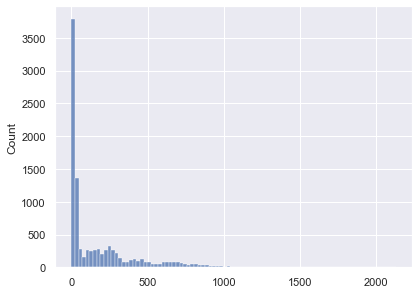

In [100]:
sns.histplot(x=BA_sizes)

#### Gráfica BA

In [101]:
n_BA = len(BA_sizes)
r_BA = np.max(BA_sizes) - np.min(BA_sizes)

iqr_BA = np.percentile(BA_sizes, 75) - np.percentile(BA_sizes, 25)

#Freedman-Diaconis
a_BA = 2*iqr_BA*n_BA**(-1/3)

k_BA = int(np.round(r_BA/a_BA, 0))

hist_BA, bin_edges_BA = np.histogram(BA_sizes, bins=k_BA)

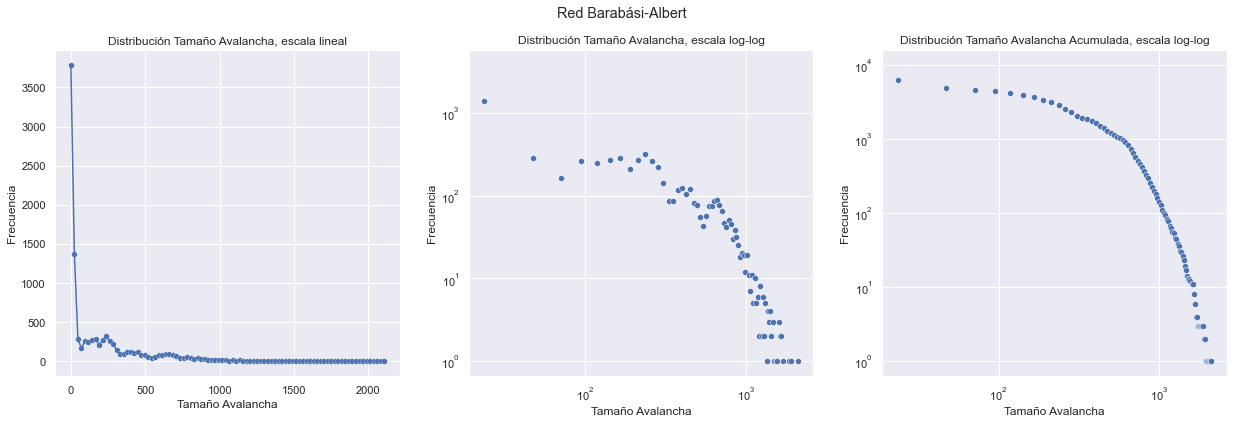

In [102]:
x_BA = bin_edges_BA[:len(hist_BA)]
y_BA = hist_BA
y_BA_cum = revcumsum(y_BA)

sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(21,6))

sns.scatterplot(x=x_BA, y=y_BA, ax=axs[0])
sns.lineplot(x=x_BA, y=y_BA, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
sns.scatterplot(x=x_BA, y=y_BA, ax=axs[1])

axs[2].set(xscale="log", yscale="log")
sns.scatterplot(x=x_BA, y=y_BA_cum, ax=axs[2])

for ax in axs:
    ax.set_xlabel("Tamaño Avalancha")
    ax.set_ylabel("Frecuencia")
axs[0].set_title("Distribución Tamaño Avalancha, escala lineal")
axs[1].set_title("Distribución Tamaño Avalancha, escala log-log")
axs[2].set_title("Distribución Tamaño Avalancha Acumulada, escala log-log")
fig.suptitle("Red Barabási-Albert")

plt.show()

#### Ajuste ER con acumulada

In [103]:
# implicit function to evaluate a powerlaw function
#PWL = lambda x, xmin, alpha: ((alpha-1)/xmin) * ((x/xmin)**(-alpha))
PWL = lambda x, alpha, C: C*(np.power(x, -alpha))

x_min = 650

x_law = np.linspace(np.min(x_BA), np.max(x_BA), 1000)

# all the variables with min are used to get the range above x_min
x_law_min = [x_law[i] for i in range(len(x_law)) if x_law[i] > x_min]

x_BA_min = [x_BA[i] for i in range(len(x_BA)) if x_BA[i] > x_min]
y_BA_cum_min = [y_BA_cum[i] for i in range(len(x_BA)) if x_BA[i] > x_min]

# now fit the curve to the powerlaw
popt, pcov = curve_fit(PWL, x_BA_min, y_BA_cum_min, maxfev = 2000)
alpha, C = popt
perr = np.sqrt(np.diag(pcov))
alpha_err, C_err = perr

# Kolmogorov Smirnov
D_max = np.max(np.abs(PWL(x_BA_min, *popt) - y_BA_cum_min))

display(Latex(f"$\\alpha = %.3f \pm %.2f$" % (alpha, alpha_err)))
display(Latex(f"$C = %.1f \pm %.1f$" % (C, C_err)))
display(Latex(f"$f(x) = %.1f \cdot X^{{-%.3f}}$" % (C, alpha)))
display(Latex(f"$D = %.3f$" % D_max))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

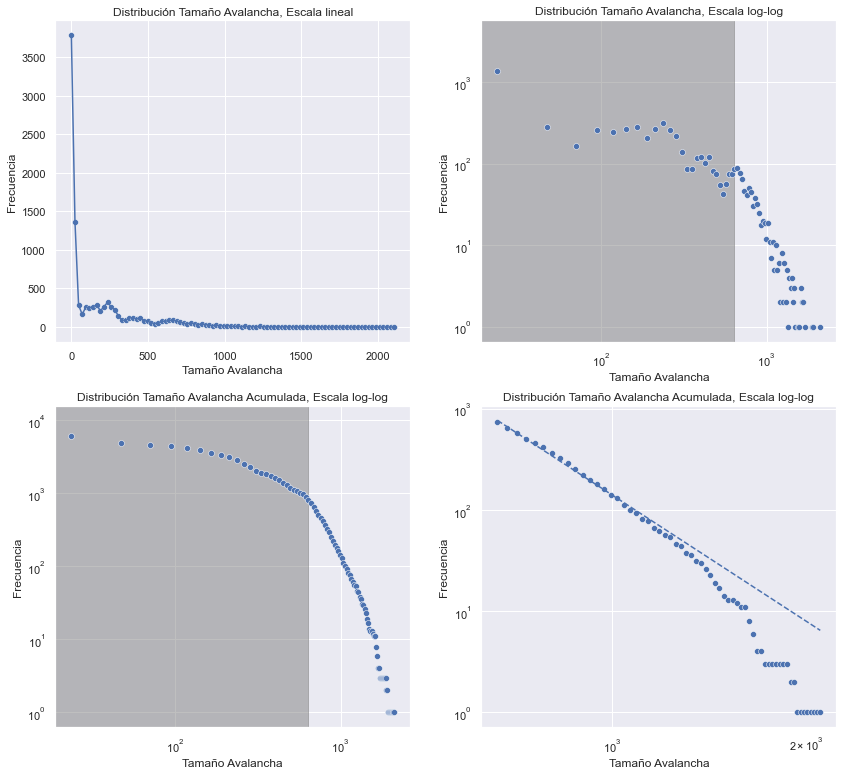

In [104]:
sns.set_theme()
sns.set_context("notebook", font_scale=1)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14,13))

axs = axs.flatten()

sns.scatterplot(x=x_BA, y=y_BA, ax=axs[0])
sns.lineplot(x=x_BA, y=y_BA, ax=axs[0])

axs[1].set(xscale="log", yscale="log")
axs[1].fill_between(x_BA, 0, 1, where= np.array(x_BA) < x_min,
                    color='grey', alpha=0.5, transform=axs[1].get_xaxis_transform())
sns.scatterplot(x=x_BA, y=y_BA, ax=axs[1])

axs[2].set(xscale="log", yscale="log")
axs[2].fill_between(x_BA, 0, 1, where= np.array(x_BA) < x_min,
                    color='grey', alpha=0.5, transform=axs[2].get_xaxis_transform())
sns.scatterplot(x=x_BA, y=y_BA_cum, ax=axs[2])

axs[3].set(xscale="log", yscale="log")
sns.scatterplot(x=x_BA_min, y=y_BA_cum_min, ax=axs[3])
axs[3].plot(x_BA_min, PWL(x_BA_min, *popt), '--')

for ax in axs:
    ax.set_xlabel(r"Tamaño Avalancha")
    ax.set_ylabel(r"Frecuencia")
axs[0].set_title(r"Distribución Tamaño Avalancha, Escala lineal")
axs[1].set_title(r"Distribución Tamaño Avalancha, Escala log-log")
axs[2].set_title(r"Distribución Tamaño Avalancha Acumulada, Escala log-log")
axs[3].set_title(r"Distribución Tamaño Avalancha Acumulada, Escala log-log")

plt.show()

In [105]:
min_dmax = 100
for x_min in range(150, 1500, 10):
    x_BA_min = [x_BA[i] for i in range(len(x_BA)) if x_BA[i] > x_min]
    y_BA_cum_min = [y_BA_cum[i] for i in range(len(x_BA)) if x_BA[i] > x_min]

    # now fit the curve to the powerlaw
    popt, pcov = curve_fit(PWL, x_BA_min, y_BA_cum_min, maxfev = 2000)
    D_max = np.max(np.abs(PWL(x_BA_min, *popt) - y_BA_cum_min))
    if min_dmax >= D_max:
        min_dmax = D_max
        print(x_min, D_max)

570 90.61646152859066
580 90.61646152859066
590 90.61646152859066
600 64.98233762104087
610 64.98233762104087
620 41.10465333258344
630 41.10465333258344
640 29.981691402292427
650 29.981691402292427
660 29.981691402292427
670 29.361685179716915
680 29.361685179716915
740 21.233895031973987
750 21.233895031973987
760 10.414878901303211
770 10.414878901303211
780 10.414878901303211
790 9.448407892627984
800 9.448407892627984
830 6.6465984872389665
840 6.6465984872389665
850 6.6465984872389665
860 6.527273789781466
870 6.527273789781466
930 6.045138323788031
940 6.045138323788031
1070 5.4102601363382306
1080 5.4102601363382306
1120 4.161773623044162
1130 4.161773623044162
1210 3.449531639866617
1220 3.449531639866617
1230 3.449531639866617
1260 2.733704166051126
1270 2.733704166051126
1310 2.6697035702184237
1320 2.6697035702184237
